In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [2]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, RDKitMinimalLib, GLM, Statistics, Plots, PyCall

import PyPlot; const plt = PyPlot;
include("../saftvrmienn.jl");

In [4]:
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1);

In [5]:
species_to_exclude_cis = ["cis-2-heptene", "(z)-1,1,1,4,4,4-hexafluorobut-2-ene", "cis-1,2-dichloroethylene",
"cis-4-octene", "(1r,2s,5r)-(-)-2-isopropyl-5-methyl-cyclohexanol", "cis-3-methyl-2-pentene", 
"cis-1,2-dimethylcyclohexane", "crotonaldehyde", ".beta.-pinene", "tricyclo[5.2.1.0(2,6)]decane",
"cis-4,4-dimethyl-2-pentene", "cis-1,2-dimethylcyclopentane", "cis-2-octene", "2-pentene", "cis-1,3-dimethyl cyclohexane",
"cis-octahydro-1h-indene", "cis-1,3-dimethylcyclopentane", "cis-1,3-dichloropropene", "cis-3-heptene",
"cis-2-decene", "d-(+)-limonene", "limonene", "cis-2,2-dimethyl-3-hexene", "cis-1,3-pentadiene", 
"(z)-1,3,3,3-tetrafluoroprop-1-ene", ".alpha.-pinene", "d-.alpha.-pinene", "cis-1,4-dimethyl cyclohexane",
"cis-decahydronaphthalene", "decalin", "cis-3-methylcyclohexanol"]

species_to_exclude_trans = ["trans-2-heptene", "(e)-1,1,1,4,4,4-hexafluorobut-2-ene", "trans-1,2-dichloroethene",
"trans-4-octene", "dl-(1r,2s,5r)-rel-5-methyl-2-(1-methylethyl)cyclohexanol", "trans-3-methyl-2-pentene", 
"trans-1,2-dimethylcyclohexane", "trans-crotonaldehyde", "(-)-beta-pinene", "exo-tricyclo[5.2.1.0(2,6)]decane",
"trans-4,4-dimethyl-2-pentene", "trans-1,2-dimethylcyclopentane", "trans-2-octene", "trans-2-pentene",
"trans-1,3-dimethyl cyclohexane", "trans-octahydro-1h-indene", "trans-1,3-dimethylcyclopentane",
"trans-1,3-dichloropropene", "trans-3-heptene", "trans-2-decene", "l-(-)-limonene", "trans-2,2-dimethyl-3-hexene",
"trans-1,3-pentadiene", "(e)-1,3,3,3-tetrafluoroprop-1-ene", "l-.alpha.-pinene", "trans-1,4-dimethylcyclohexane",
"trans-decahydronaphthalene", "trans-3-methylcyclohexanol"]

# append!(species_to_exclude_cis,species_to_exclude_trans)

pcp_source_params_isomers_removed = filter(row -> !(row.common_name in species_to_exclude_cis), pcp_source_params);


In [7]:
chemical_family = "All Species"

if lowercase(chemical_family) == "linear alkanes"
    contains_only_c(name) = all(letter -> lowercase(letter) == 'c', name);
    processed_data_lin_alkanes = filter(row -> contains_only_c(row.isomeric_SMILES), pcp_source_params_isomers_removed) 
    processed_data = sort(processed_data_lin_alkanes, :Mw)
else
    if lowercase(chemical_family) == "all species"
        processed_data = pcp_source_params_isomers_removed
    else
        processed_data = filter(row -> lowercase(row.family) == lowercase(chemical_family), pcp_source_params_isomers_removed) 
        processed_data = sort(processed_data, :Mw)
    end
end

processed_data = sort(processed_data, :family)


processed_data.isomeric_SMILES;
# println(processed_data);

In [171]:
isomeric_smiles = processed_data[!,:isomeric_SMILES]

fingerprints = []

for i in isomeric_smiles
    fingerprint_spec_i = []

    mol = get_mol(i)

    fp_str1 = get_topological_torsion_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    # fp_str1 = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    # fp_str1 = get_pattern_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    # fp_str2 = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    # fp_str = get_rdkit_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))


    fp_str = fp_str1 #* fp_str2
    
    append!(fingerprint_spec_i, [parse(Float64, string(c)) for c in fp_str])

    desc = get_descriptors(mol)
    relevant_keys = ["CrippenClogP", "NumHeavyAtoms", "amw", "FractionCSP3"]

    relevant_desc = [desc[k] for k in relevant_keys]
    # append!(fingerprint_spec_i, relevant_desc)
    append!(fingerprints, [fingerprint_spec_i])

end

println(length(fingerprints[1]))

2048


In [173]:
# Remove repeated columns
for num = [0, 1]
    num_cols = length(fingerprints[1])
    zero_cols = trues(num_cols)
    for vec in fingerprints
        zero_cols .&= (vec .== num)
    end
    keep_cols = .!zero_cols # Create a Mask
    fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
end

println(length(fingerprints[1]))

0


In [160]:
function count_repeated_vectors(arr)
    vector_counts = Dict{Vector, Int}()

    for vector in arr
        if haskey(vector_counts, vector)
            vector_counts[vector] += 1
        else
            vector_counts[vector] = 1
        end
    end

    repeated_vectors = filter(kv -> kv[2] > 1, vector_counts)
    return repeated_vectors
end

function compare_fingerprints(vectors::Vector{Vector{T}}) where T
    n = length(vectors)
    jaccard_matrix = ones(Float64, n, n)
    total_differences = 0
    differences = []
    jaccard_coefficients = []
    counts = Dict{Int, Int}()

    for i in 1:n
        for j in i+1:n
            # Count the number of differing elements
            diff_count = sum(vectors[i] .!= vectors[j])

            # Count the number of common elements
            common_count = length(vectors[i]) - diff_count

            # append dictionary tracking the number of pairs that differ by a given number of counts
            counts[diff_count] = get(counts, diff_count, 0) + 1
            push!(differences, diff_count)

            # append variable tracking the total number of differences over all pairs
            total_differences += diff_count

            # compute the jaccard coefficient and push
            jaccard_coefficient = common_count / (length(vectors[i]) + length(vectors[j]) - common_count)
            push!(jaccard_coefficients, jaccard_coefficient)

            # store the coefficient in the matrix symmetrically
            jaccard_matrix[i, j] = jaccard_coefficient
            jaccard_matrix[j, i] = jaccard_coefficient
        end
    end
    average_diff = total_differences / (n * (n - 1) / 2)  # n choose 2
    average_jaccard = mean(jaccard_coefficients)
    # std_diff = std(differences)
    return counts, average_diff, average_jaccard, jaccard_matrix
end;

function find_interval_indices(value, intervals)
    for (i, interval) in enumerate(intervals[1:end-1])
        if value >= interval && value < intervals[i+1]
            return i
        end
    end
    return length(intervals) - 1
end;

In [161]:
# Fingerprint comparisons for a given chemical family
repeated_vectors = count_repeated_vectors(fingerprints)
number_repeated_strings = length(values(repeated_vectors))

for i in keys(repeated_vectors)
    # Use a list comprehension to find indices where the vector matches the target_key
    matching_indices = findall(vector -> vector == i, fingerprints)
    for i in  matching_indices
        println(processed_data[i,:common_name])
    end
end

@show number_repeated_strings
result_compare = compare_fingerprints(fingerprints)

number_repeated_strings = 0


(Dict(6 => 15, 7 => 18, 2 => 3), 6.166666666666667, 0.5947063688999172, [1.0 0.6 … 0.6 0.6; 0.6 1.0 … 0.6 0.6; … ; 0.6 0.6 … 1.0 0.6; 0.6 0.6 … 0.6 1.0])

In [162]:
function zero_out_lower_triangle(matrix)
    n = size(matrix, 1)
    for i in 2:n
        for j in 1:i-1
            matrix[i, j] = NaN
        end
    end
    return matrix
end;

0.5483870967741935


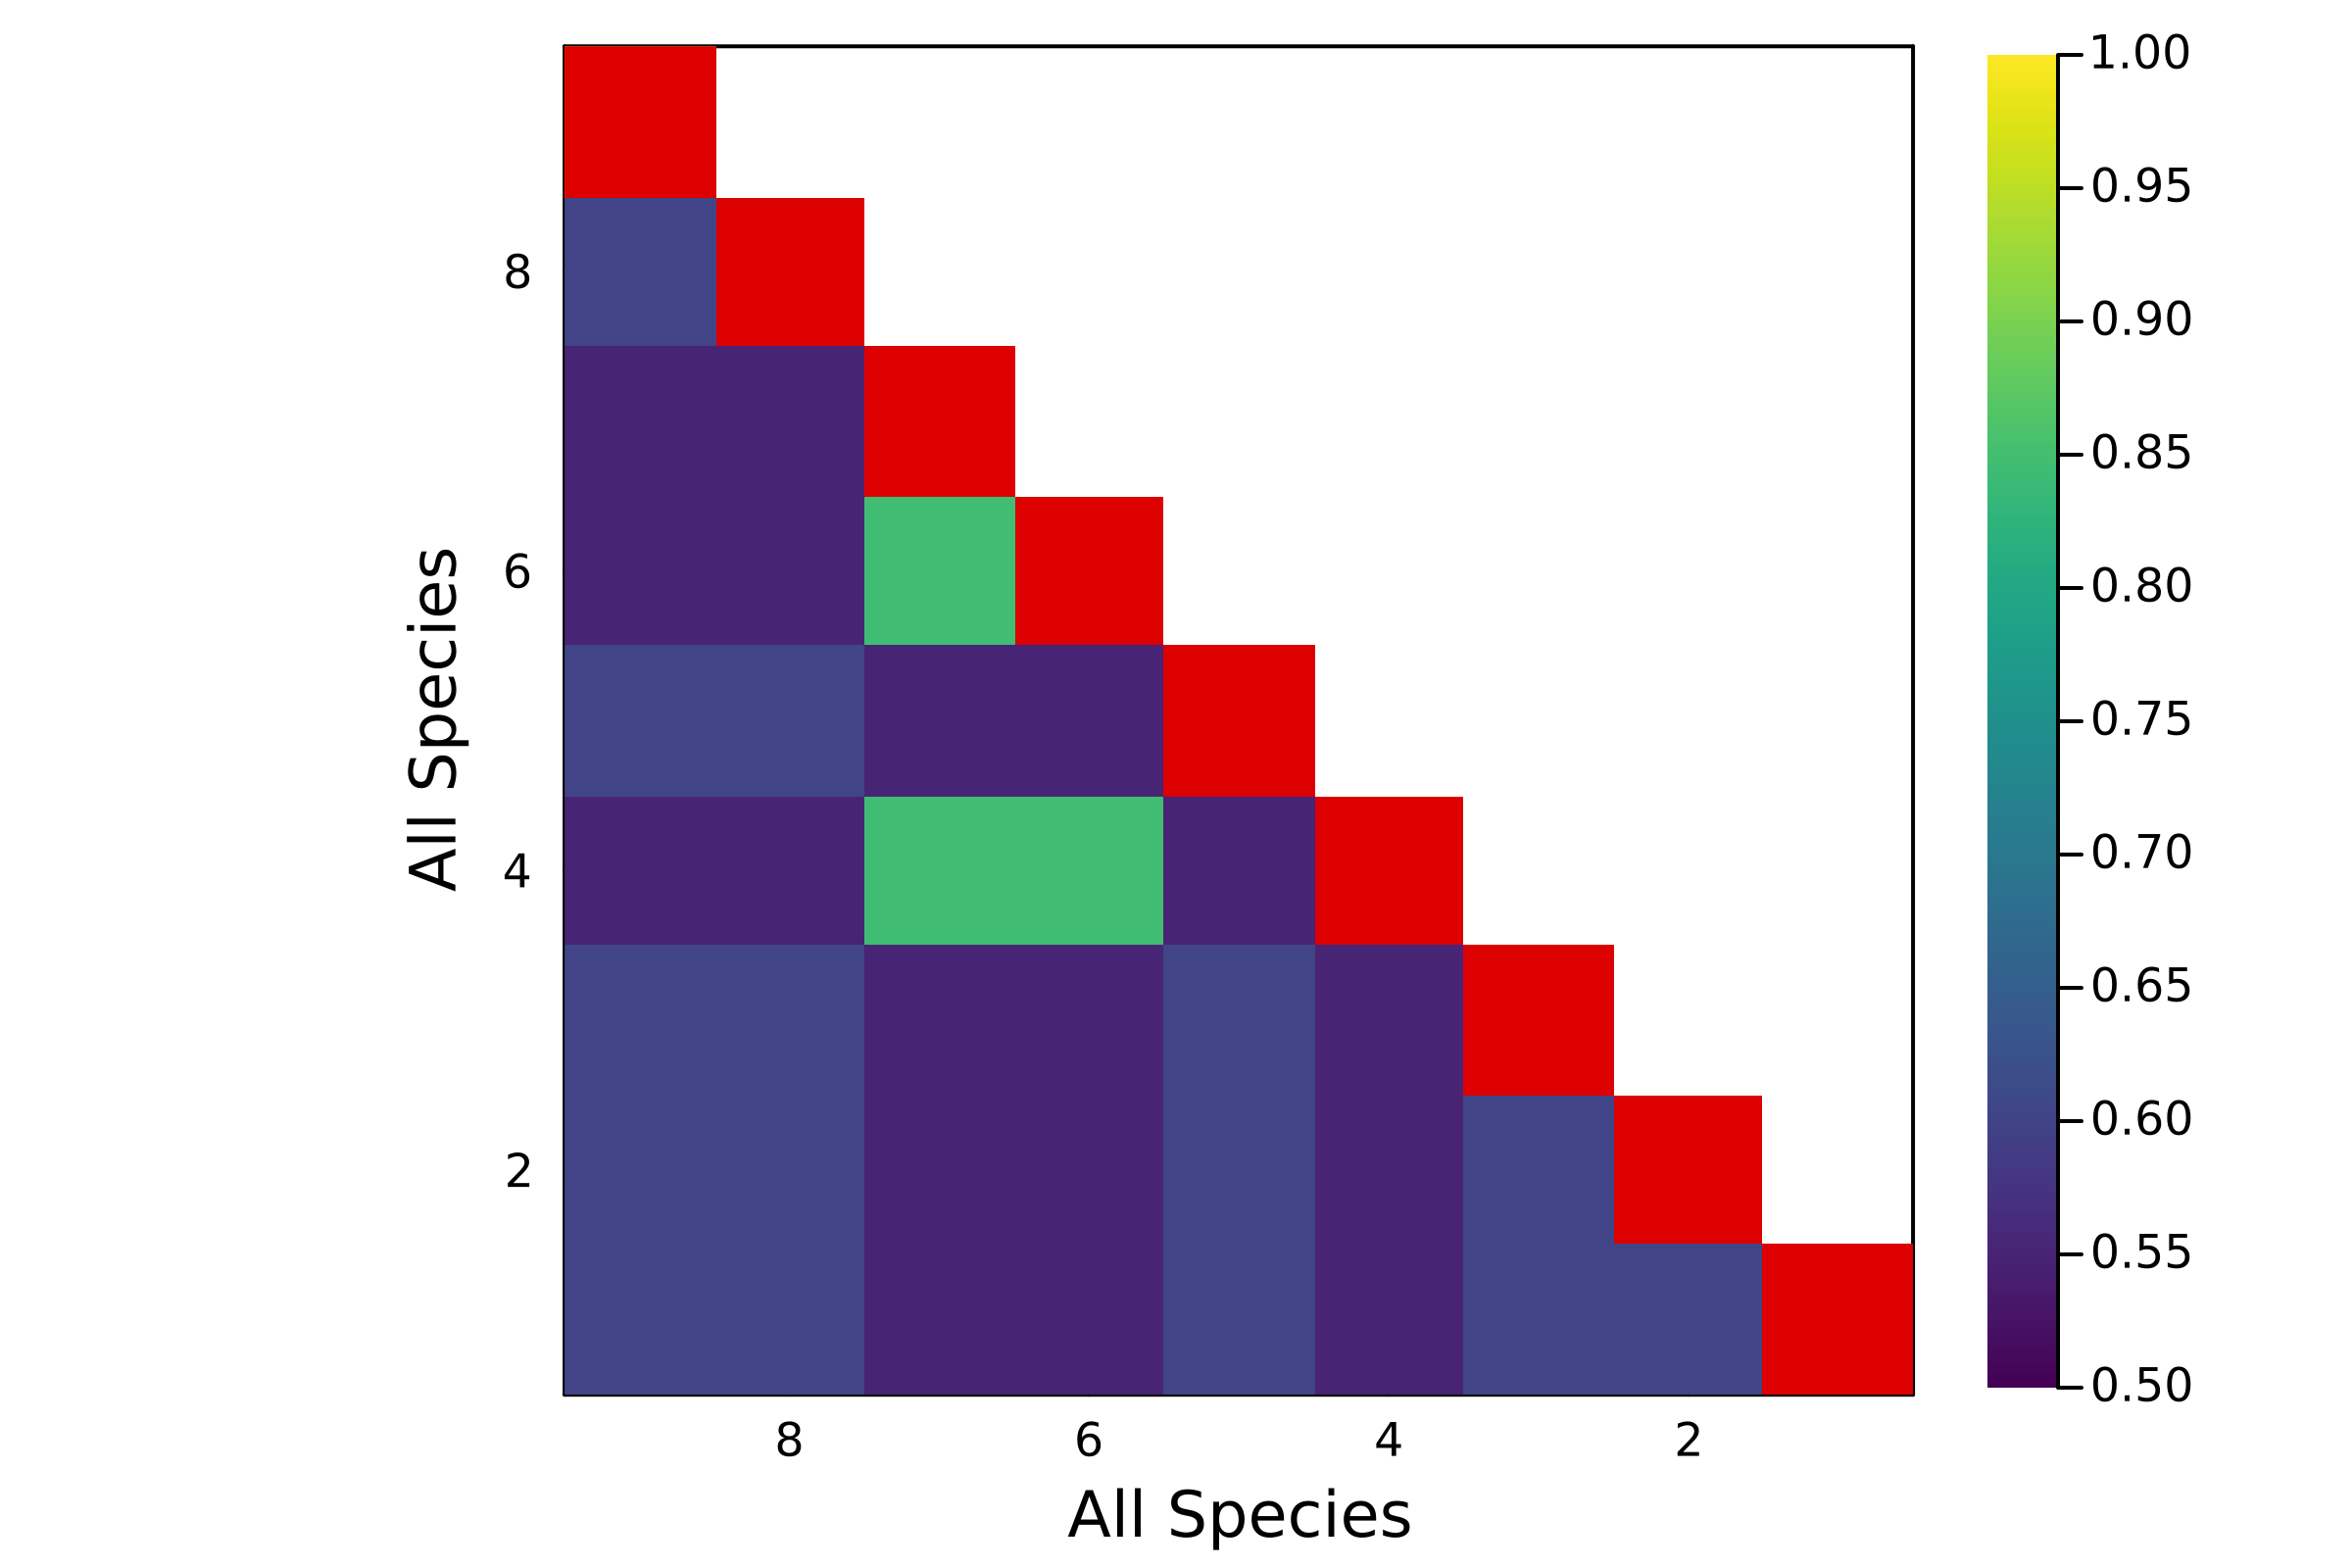

In [170]:
# Extract the Jaccard coefficients from the result
jaccard_vector = result_compare[4]
clims = (0.5, 1)
axis_title = "All Species"
bound_upper = 9.5

# Assuming the length of jaccard_vector is a perfect square
n = isqrt(length(jaccard_vector))

jaccard_matrix = reshape(jaccard_vector, (n, n))
min_value = minimum(jaccard_matrix[.!isnan.(jaccard_matrix) .& (jaccard_matrix .!= 0)])
println(min_value)

jaccard_matrix = zero_out_lower_triangle(jaccard_matrix)

updated_jaccard_matrix = copy(jaccard_matrix)
updated_jaccard_matrix[jaccard_matrix .!= 1] .= 0

# custom_map = [RGBA(1, 0, 0, 1), RGBA(0, 1, 0, 1), RGBA(0, 0, 1, 1), RGBA(0, 0, 0, 0)]
custom_map = cgrad([RGBA(220/255,0,0,0), RGBA(220/255,0,0,1)])

plot1 = heatmap(jaccard_matrix,dpi=400,c=:viridis, color=:viridis, aspect_ratio=:equal, xlims=(0, bound_upper),framestyle=:box,clims=clims,colorbar=true,xflip=true,grid=false,fontsize=12)
plot2 = heatmap!(updated_jaccard_matrix, dpi=400, c=custom_map, xlabel=axis_title, ylabel=axis_title, aspect_ratio=:equal,xlims=(0.5, bound_upper),framestyle=:box, clims=clims,colorbar=false,xflip=true,grid=false,fontsize=12)  # Set clims based on the first plot

p_all = scatter!([NaN], [NaN], zcolor=[NaN], clims=clims, label="", c=:viridis, background_color_subplot=:transparent, markerstrokecolor=:transparent, framestyle=:none, inset=bbox(0.075, -0.04, 0.55, 0.85, :center, :right), subplot=2)

# annotate!([(0.5, -2, text("0", 8, :DejaVuSans))])
# annotate!([(83.25, 1, text("0", 8, :DejaVuSans))])
# annotate!([(-20, 40, text("Jaccard Coefficient", 12, :DejaVuSans, rotation=90))])
annotate!([(-450, 900, text("Jaccard Coefficient", 12, :DejaVuSans, rotation=90))])

plot!()  # Use plot!() to display the plot

# savefig("fingerprint_heatmap_all_species.png");


number_repeated_strings = 93
mean_bits_in_common_between_pairs = 14.648686768760621
std_dev_bits_in_common_between_pairs = 7.810076819728682


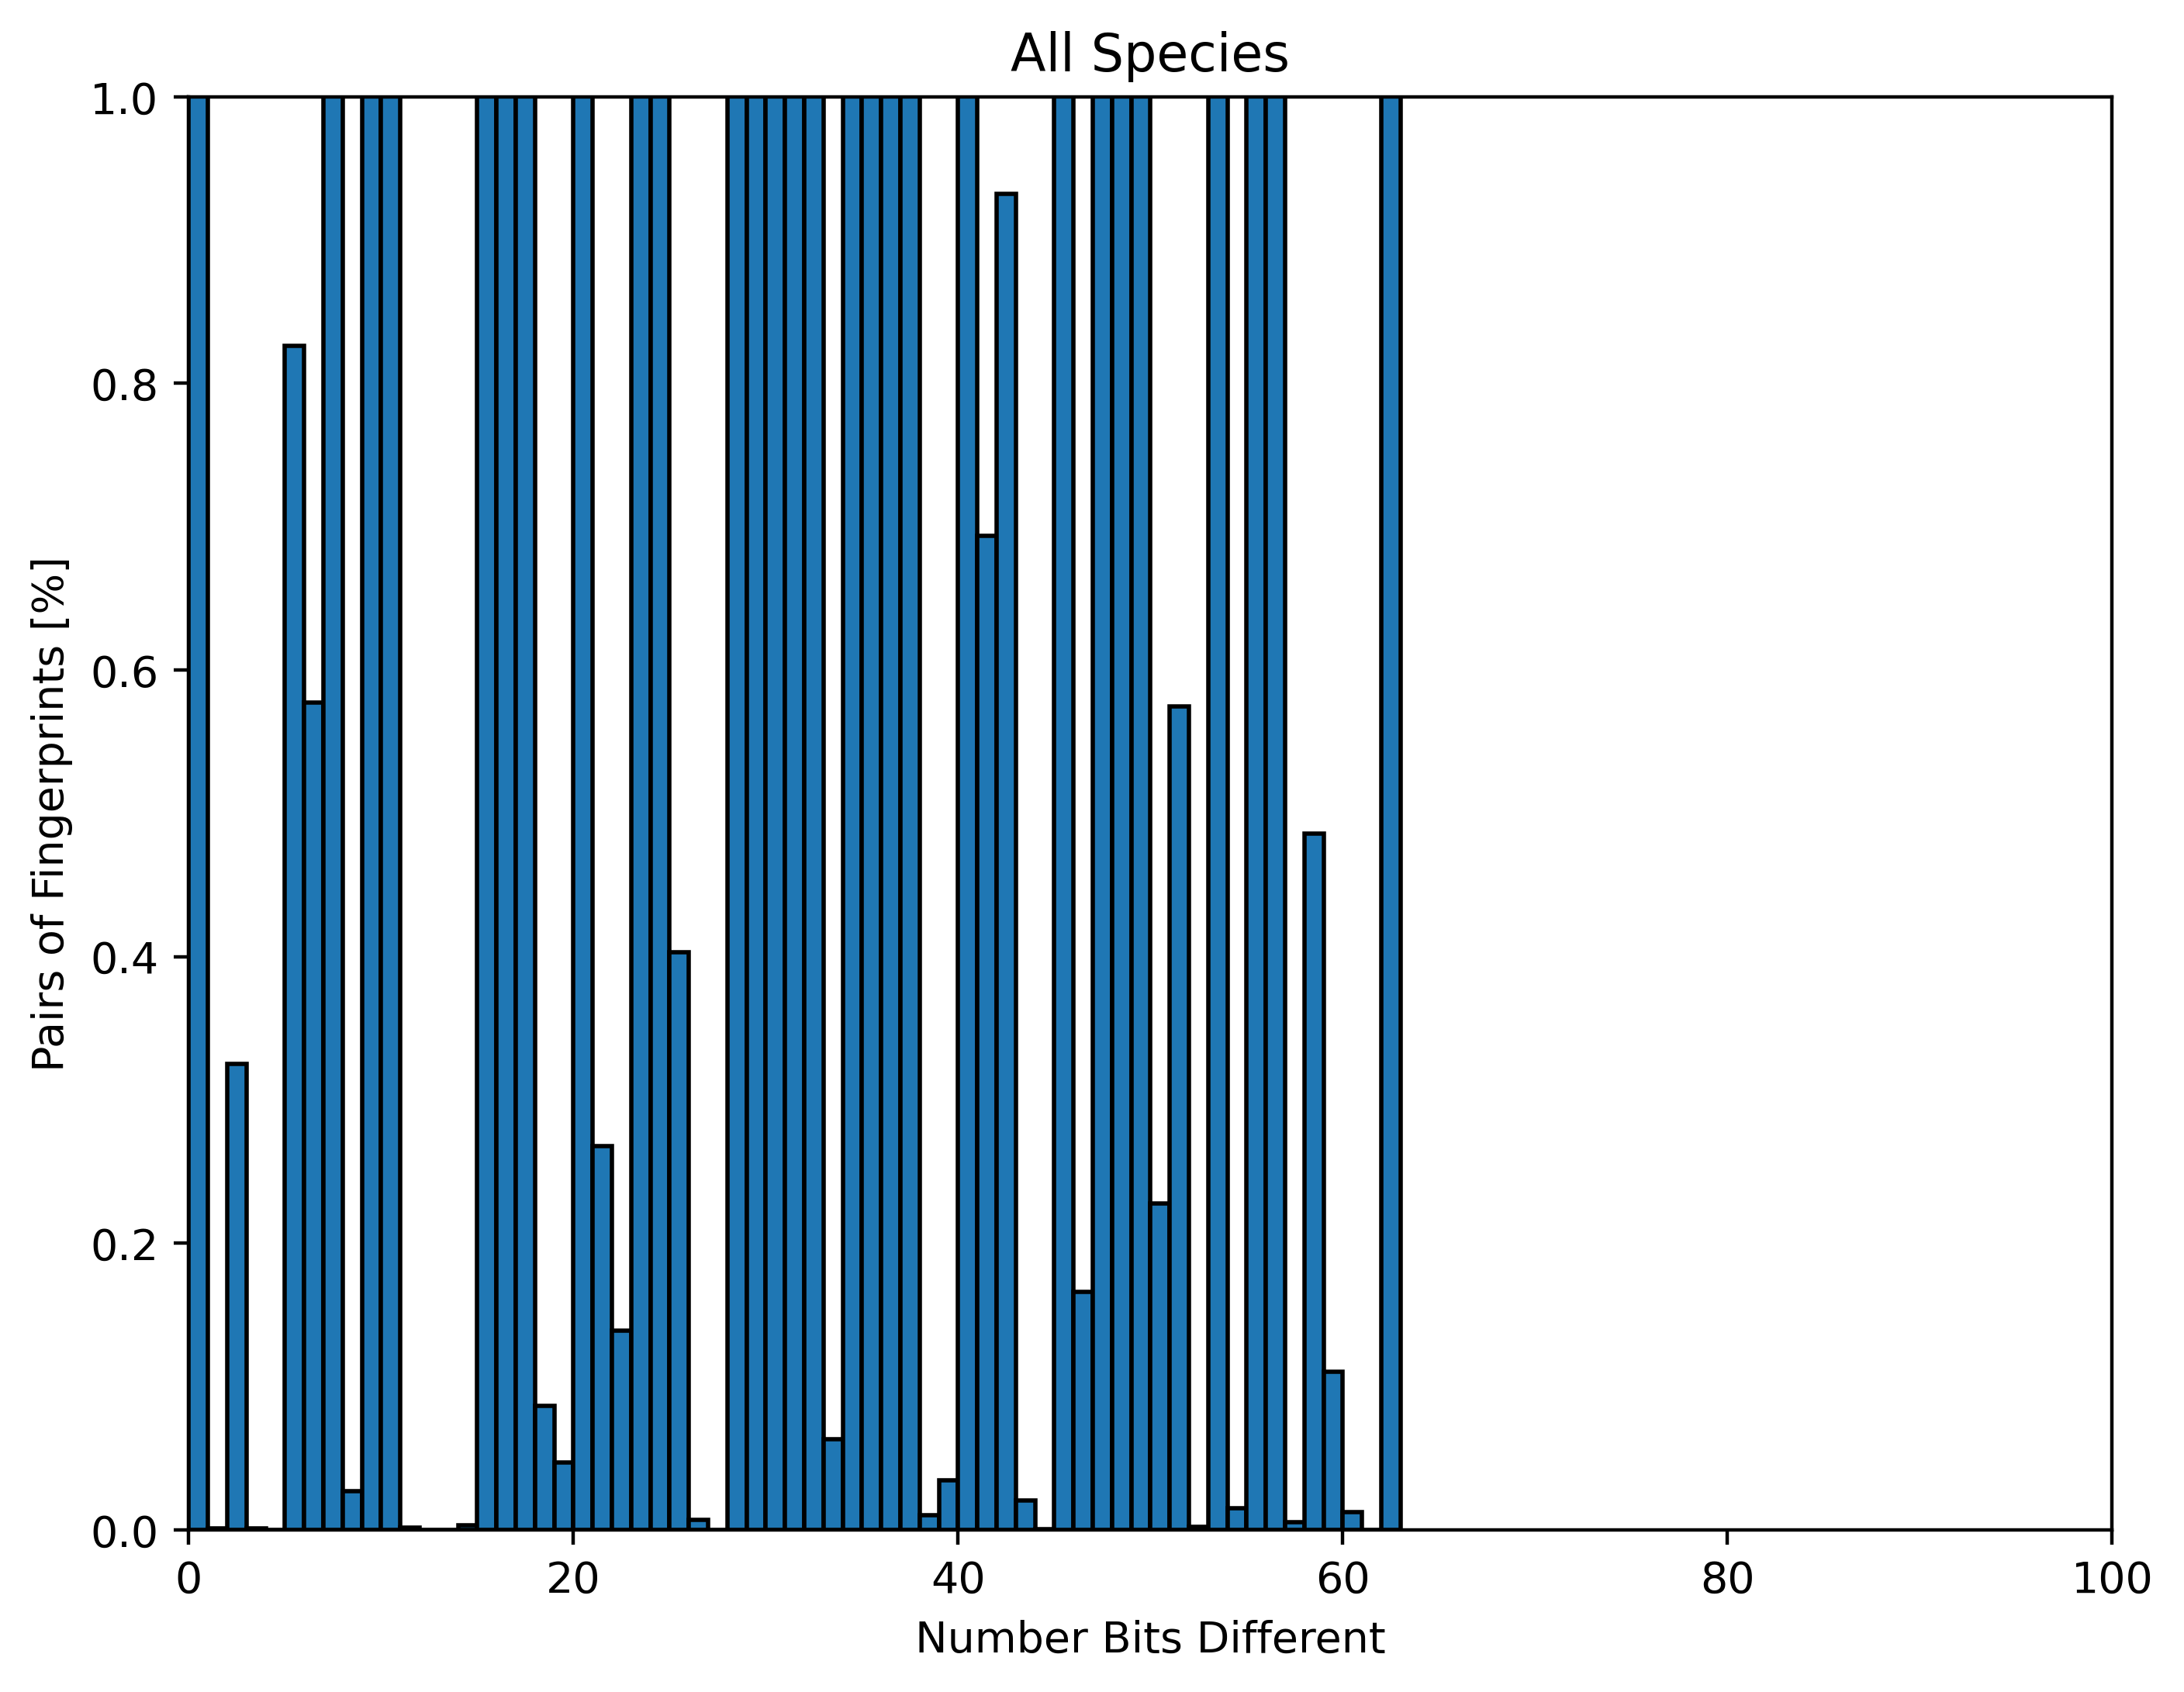

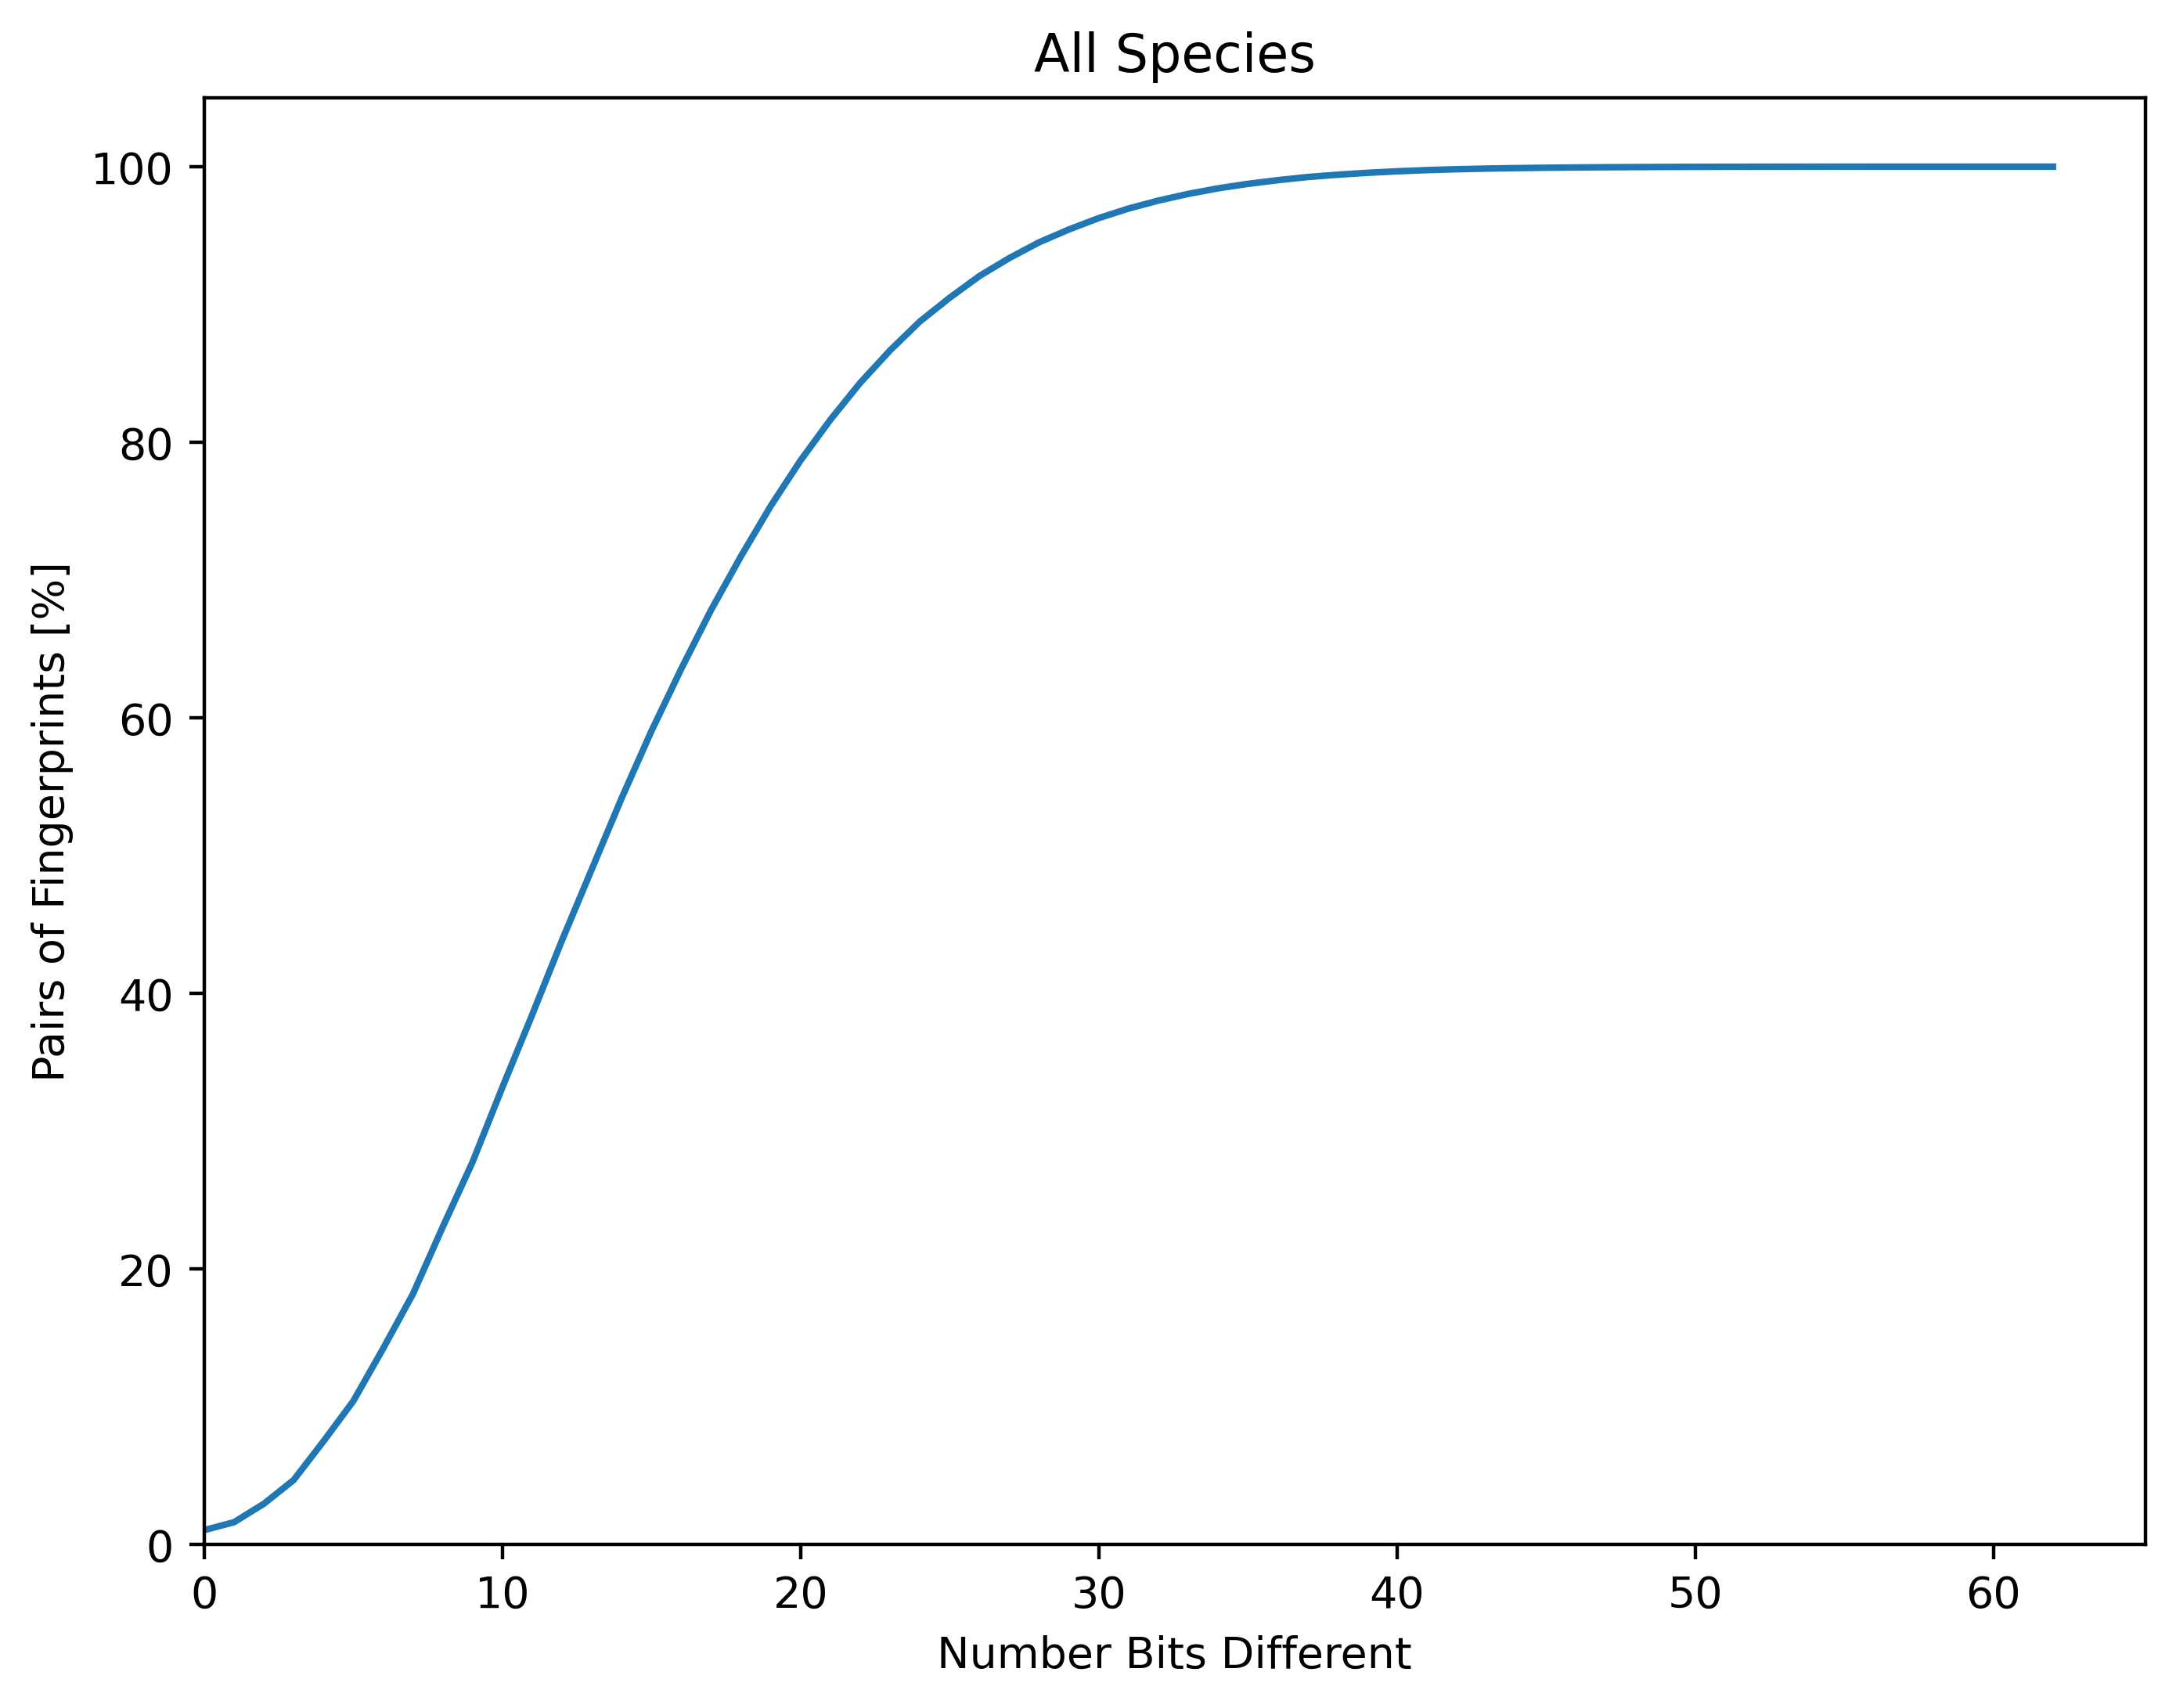

In [15]:
n_pairs = collect(values(result_compare[1]))
total_count = sum(values(result_compare[1]))
proportion_pairs = n_pairs ./total_count

n_bits_different = collect(keys(result_compare[1]))
n_bits_different_sorted = sort(collect(keys(result_compare[1])))

cumulative_probabilities = cumsum([get(result_compare[1], v, 0) for v in n_bits_different_sorted]) / sum([get(result_compare[1], v, 0) for v in n_bits_different_sorted])

mean_bits_in_common_between_pairs = result_compare[2]
std_dev_bits_in_common_between_pairs = result_compare[3]

@show number_repeated_strings
@show mean_bits_in_common_between_pairs
@show std_dev_bits_in_common_between_pairs

# Calculate intervals of 10 for number of bits different
n_bits_interval = 1
n_bits_intervals = 0:n_bits_interval:maximum(n_bits_different_sorted) + n_bits_interval

# Group the data into intervals
interval_indices = [find_interval_indices(v, n_bits_intervals) for v in n_bits_different_sorted]

# Calculate aggregated values for each interval
aggregated_proportion_pairs = [sum(proportion_pairs[interval_indices .== i]) for i in 1:length(n_bits_intervals)-1]
interval_centers = (n_bits_intervals[1:end-1] + n_bits_intervals[2:end]) / 2

# Bar Chart
plt.figure(figsize=(8, 6), dpi=400)
plt.bar(interval_centers, aggregated_proportion_pairs * 100, width=n_bits_interval, edgecolor="black")
plt.xlabel("Number Bits Different")
plt.ylabel("Pairs of Fingerprints [%]")
plt.title(chemical_family)
plt.ylim([0, 1])
plt.xlim([0, 100])

# ECDF
plt.figure(figsize=(8, 6), dpi=400)
plt.plot(n_bits_different_sorted, cumulative_probabilities * 100, label="ECDF")
plt.xlabel("Number Bits Different")
plt.ylabel("Pairs of Fingerprints [%]")
plt.title(chemical_family)
plt.ylim([0, 105])
plt.xlim([0, nothing]);


In [ ]:
unique_values = unique(processed_data[!, :family])
num_rows = length(unique_values) + 1

# number repeated strings, repeated strings, 

processed_data = DataFrame(
    chemical_family = fill(missing, num_rows),
    rdkit_reps = fill(missing, num_rows),
    rdkit_rep_st = fill(missing,num_rows),
    inchi = fill(missing,num_rows),
    canonical_SMILES = fill(missing,num_rows),
    isomeric_SMILES = fill(missing, num_rows), 
    family = fill(missing, num_rows),
    Mw = fill(missing, num_rows),
    segment = fill(missing, num_rows),
    sigma = fill(missing, num_rows),
    epsilon = fill(missing, num_rows),
    dipole = fill(missing, num_rows),
    kappa_ab = fill(missing, num_rows),
    epsilon_k_ab = fill(missing, num_rows),
    na = fill(missing, num_rows),
    nb = fill(missing, num_rows),
    expt_p_sat_T_min = fill(missing, num_rows),
    expt_p_sat_T_max = fill(missing, num_rows),
    expt_density_T_min = fill(missing, num_rows),
    expt_density_T_max = fill(missing, num_rows),
    interaction = fill(missing,num_rows),
    bounds_violation = fill(missing,num_rows),
    source = fill(missing, num_rows)
) ;

In [45]:
# This plots the CFDs for mutliple fingerprints

n_bits_different_sorted_all_fp = []
cumulative_percentiles_all_fp = []
number_repeated_strings_all_fp = []
mean_bits_in_common_between_pairs_all_fp = []
std_dev_bits_in_common_between_pairs_all_fp = []

isomeric_smiles = processed_data[!,:isomeric_SMILES]

fingerprints_rdkit = []
fingerprints_morgan = []
fingerprints_pattern = []
fingerprints_atom_pair = []

fingerprints_rdkit_morgan = []
fingerprints_rdkit_pattern = []
fingerprints_rdkit_morgan_pattern = []

fingerprints_atom_pair_morgan = []
fingerprints_atom_pair_pattern = []
fingerprints_atom_pair_morgan_pattern = []

fingerprints_atom_pair_morgan_pattern_rdkit = []

for i in isomeric_smiles
    
    mol = get_mol(i)

    fingerprint_spec_i_rdkit = []
    fingerprint_spec_i_morgan = []
    fingerprint_spec_i_pattern = []
    fingerprint_spec_i_atom_pair = []

    fingerprint_spec_i_rdkit_morgan = []
    fingerprint_spec_i_rdkit_pattern = []
    fingerprint_spec_i_rdkit_morgan_pattern = []

    fingerprint_spec_i_atom_pair_morgan = []
    fingerprint_spec_i_atom_pair_pattern = []
    fingerprint_spec_i_atom_pair_morgan_pattern = []

    fingerprint_spec_i_atom_pair_morgan_pattern_rdkit = []

    fp_str_spec_i_rdkit = get_rdkit_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    fp_str_spec_i_morgan = get_morgan_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    fp_str_spec_i_pattern = get_pattern_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    fp_str_spec_i_atom_pair = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))

    fp_str_spec_i_rdkit_morgan = fp_str_spec_i_rdkit * fp_str_spec_i_morgan
    fp_str_spec_i_rdkit_pattern = fp_str_spec_i_rdkit * fp_str_spec_i_pattern
    fp_str_spec_i_rdkit_morgan_pattern = fp_str_spec_i_rdkit * fp_str_spec_i_morgan * fp_str_spec_i_pattern

    fp_str_spec_i_atom_pair_morgan = fp_str_spec_i_atom_pair * fp_str_spec_i_morgan
    fp_str_spec_i_atom_pair_pattern = fp_str_spec_i_atom_pair * fp_str_spec_i_pattern
    fp_str_spec_i_atom_pair_morgan_pattern = fp_str_spec_i_atom_pair * fp_str_spec_i_morgan * fp_str_spec_i_pattern

    fp_str_spec_i_atom_pair_morgan_pattern_rdkit = fp_str_spec_i_atom_pair * fp_str_spec_i_morgan * fp_str_spec_i_pattern * fp_str_spec_i_rdkit
    
    append!(fingerprint_spec_i_rdkit, [parse(Float64, string(c)) for c in fp_str_spec_i_rdkit])
    append!(fingerprint_spec_i_morgan, [parse(Float64, string(c)) for c in fp_str_spec_i_morgan])
    append!(fingerprint_spec_i_pattern, [parse(Float64, string(c)) for c in fp_str_spec_i_pattern])
    append!(fingerprint_spec_i_atom_pair, [parse(Float64, string(c)) for c in fp_str_spec_i_atom_pair])

    append!(fingerprint_spec_i_rdkit_morgan, [parse(Float64, string(c)) for c in fp_str_spec_i_rdkit_morgan])
    append!(fingerprint_spec_i_rdkit_pattern, [parse(Float64, string(c)) for c in fp_str_spec_i_rdkit_pattern])
    append!(fingerprint_spec_i_rdkit_morgan_pattern, [parse(Float64, string(c)) for c in fp_str_spec_i_rdkit_morgan_pattern])

    append!(fingerprint_spec_i_atom_pair_morgan, [parse(Float64, string(c)) for c in fp_str_spec_i_atom_pair_morgan])
    append!(fingerprint_spec_i_atom_pair_pattern, [parse(Float64, string(c)) for c in fp_str_spec_i_atom_pair_pattern])
    append!(fingerprint_spec_i_atom_pair_morgan_pattern, [parse(Float64, string(c)) for c in fp_str_spec_i_atom_pair_morgan_pattern])

    append!(fingerprint_spec_i_atom_pair_morgan_pattern_rdkit, [parse(Float64, string(c)) for c in fp_str_spec_i_atom_pair_morgan_pattern_rdkit])

    # desc = get_descriptors(mol)
    # relevant_keys = ["CrippenClogP", "NumHeavyAtoms", "amw", "FractionCSP3"]
    # relevant_desc = [desc[k] for k in relevant_keys]
    # append!(fingerprint_spec_i, relevant_desc)

    append!(fingerprints_rdkit, [fingerprint_spec_i_rdkit])
    append!(fingerprints_morgan, [fingerprint_spec_i_morgan])
    append!(fingerprints_pattern, [fingerprint_spec_i_pattern])
    append!(fingerprints_atom_pair, [fingerprint_spec_i_atom_pair])

    append!(fingerprints_rdkit_morgan, [fingerprint_spec_i_rdkit_morgan])
    append!(fingerprints_rdkit_pattern, [fingerprint_spec_i_rdkit_pattern])
    append!(fingerprints_rdkit_morgan_pattern, [fingerprint_spec_i_rdkit_morgan_pattern])

    append!(fingerprints_atom_pair_morgan, [fingerprint_spec_i_atom_pair_morgan])
    append!(fingerprints_atom_pair_pattern, [fingerprint_spec_i_atom_pair_pattern])
    append!(fingerprints_atom_pair_morgan_pattern, [fingerprint_spec_i_atom_pair_morgan_pattern])

    append!(fingerprints_atom_pair_morgan_pattern_rdkit, [fingerprint_spec_i_atom_pair_morgan_pattern_rdkit])

end

all_fingerprints = [fingerprints_rdkit, fingerprints_morgan, fingerprints_pattern, fingerprints_atom_pair, 
fingerprints_rdkit_morgan, fingerprints_rdkit_pattern, fingerprints_rdkit_morgan_pattern, fingerprints_atom_pair_morgan,
fingerprints_atom_pair_pattern, fingerprints_atom_pair_morgan_pattern, fingerprints_atom_pair_morgan_pattern_rdkit]

for fingerprints in all_fingerprints
# Remove repeated columns
    for num = [0, 1]
        num_cols = length(fingerprints[1])
        zero_cols = trues(num_cols)
        for vec in fingerprints
            zero_cols .&= (vec .== num)
        end
        keep_cols = .!zero_cols # Create a Mask
        fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
    end

    # Fingerprint comparisons for a given chemical family
    repeated_vectors = count_repeated_vectors(fingerprints)
    number_repeated_strings = length(values(repeated_vectors))

    for i in keys(repeated_vectors)
        # Use a list comprehension to find indices where the vector matches the target_key
        matching_indices = findall(vector -> vector == i, fingerprints)
        for i in  matching_indices
            println(processed_data[i,:species]) # comment this in to print the names of repeated species
        end
    end

    result_compare = compare_fingerprints(fingerprints)

    n_pairs = collect(values(result_compare[1]))
    total_count = sum(values(result_compare[1]))
    proportion_pairs = n_pairs ./total_count

    n_bits_different = collect(keys(result_compare[1]))
    n_bits_different_sorted = sort(collect(keys(result_compare[1])))

    cumulative_probabilities = cumsum([get(result_compare[1], v, 0) for v in n_bits_different_sorted]) / sum([get(result_compare[1], v, 0) for v in n_bits_different_sorted])

    mean_bits_in_common_between_pairs = result_compare[2]
    std_dev_bits_in_common_between_pairs = result_compare[3]

    push!(number_repeated_strings_all_fp, number_repeated_strings)
    push!(mean_bits_in_common_between_pairs_all_fp, mean_bits_in_common_between_pairs)
    push!(std_dev_bits_in_common_between_pairs_all_fp, std_dev_bits_in_common_between_pairs)

    push!(n_bits_different_sorted_all_fp,n_bits_different_sorted)
    push!(cumulative_percentiles_all_fp,cumulative_probabilities*100)
    # ECDF

    @show number_repeated_strings
    
end

1,3-dimethyl adamantane
1-ethyltricyclo(3.3.1.1(3,7))decane
1,3,5-trimethyladamantane
diethylene glycol monobutyl ether
diethylene glycol dibutyl ether
propane
tripropylaluminum
methyl oleate
methyl erucate
tripropylene glycol
tetrapropylene glycol
2-octanone
2-nonanone
2-undecanone
trimethylene glycol dimethyl ether
tetramethylene glycoldimethyl ether
octanenitrile
1,6-dicyanohexane
nonanenitrile
decanoic acid butyl ester
dodecanoic acid butyl ester
decanedioic acid dibutyl ester
cyclooctanone
3-nonanone
cycloundecanone
cyclododecanone
caprylic acid
nonanoic acid
capric acid
undecanoic acid
lauric acid
tridecanoic acid
myristic acid
pentadecanoic acid
palmitic acid
margarinic acid
stearic acid
nonadecanoic acid
arachidic acid
octylmercaptan
nonylmercaptan
1-decanethiol
n-dodecyl mercaptan
isopropyl tert-butyl ether
di-tert-butyl ether
diethylene glycol monomethyl ether
diethylene glycol dimethyl ether
methane
ammonia
water
hydrogen fluoride
silane
hydrogen sulfide
phosphorous trihydri

In [38]:
num_rows = length(n_bits_different_sorted_all_fp)

ecdf_data = DataFrame(
    n_bits_different_sorted_all_fp = fill([0.0], num_rows),
    cumulative_percentiles_all_fp = fill([0.0], num_rows)
) ;

for i = 1:length(n_bits_different_sorted_all_fp)
    ecdf_data[i,:cumulative_percentiles_all_fp] = cumulative_percentiles_all_fp[i]
    ecdf_data[i,:n_bits_different_sorted_all_fp] = n_bits_different_sorted_all_fp[i]
end

CSV.write("ecdf_data_all_fp.csv", ecdf_data)


LoadError: UndefVarError: `n_bits_different_sorted_all_fp` not defined

In [54]:
plt.figure(figsize=(8, 6), dpi=400)

for i = 1:length(n_bits_different_sorted_all_fp)
    plt.plot(n_bits_different_sorted_all_fp[i], cumulative_percentiles_all_fp[i], label="ECDF")
end

plt.xlabel("Number Bits Different")
plt.ylabel("Pairs of Fingerprints [%]")
plt.title(chemical_family)
plt.legend(["rdkit","morgan","pattern","atom_pair","rdkit + morgan","rdkit + pattern","rdkit + morgan + pattern",
"atom_pair + morgan","atom_pair + pattern","atom_pair + morgan + pattern","atom_pair + rdkit + morgan + pattern"],loc = "lower right")
plt.ylim([0, 105])
plt.xlim([0, nothing]);

plt.figure(figsize=(8, 6), dpi=400)

for i = 1:length(n_bits_different_sorted_all_fp)
    plt.plot(n_bits_different_sorted_all_fp[i] ./n_bits_different_sorted_all_fp[i][end], cumulative_percentiles_all_fp[i], label="ECDF")
end

plt.xlabel("Fraction Max. Number Bits Different")
plt.ylabel("Pairs of Fingerprints [%]")
plt.title(chemical_family)
plt.legend(["rdkit","morgan","pattern","atom_pair","pattern + atom_pair"],loc = "lower right")

plt.ylim([0, 105])
plt.xlim([0, 1]);

# rd_kit,  atom_pair, topological_torsion, unable to distibguish between non-carbon-containing things, but pattern and morgan
# can => concatenate at least one from each of these sets

# rdkit
# atom_pair
# topological_torsion
# morgan
# pattern

# rdkit + morgan
# rdkit + pattern
# rdkit + atom_pair
# rdkit + topological_torsion
# atom_pair + morgan
# atom_pair + pattern # tried this
# atom_pair + topological_torsion
# topological_torsion + morgan
# topological_torsion + pattern
# morgan + pattern

# rdkit + atom_pair + topological_torsion
# rdkit + atom_pair + morgan
# rdkit + atom_pair + pattern
# rdkit + topological_torsion + morgan
# rdkit + topological_torsion + pattern
# rdkit + morgan + pattern
# atom_pair + topological_torsion + morgan
# atom_pair + topological_torsion + pattern
# atom_pair + morgan + pattern
# topological_torsion + morgan + pattern

# rdkit + atom_pair + topological_torsion + morgan
# rdkit + atom_pair + topological_torsion + pattern
# rdkit + atom_pair + morgan + pattern
# rdkit + topological_torsion + morgan + pattern
# atom_pair + topological_torsion + morgan + pattern

# rdkit + atom_pair + topological_torsion + morgan + pattern

LoadError: UndefVarError: `n_bits_different_sorted_all_fp` not defined

In [27]:
unique_values = unique(processed_data[!, :family])
means_all = []
std_devs_all = []

for i in unique_values
    println(i)
    filtered_data_chem_family = filter(row -> row.family == i, pcp_source_params) ;
    filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 
    isomeric_smiles_family = filtered_data_chem_family[!,:isomeric_SMILES]

    fingerprints_rdkit = []
    fingerprints_morgan = []
    fingerprints_atom_pair = []
    fingerprints_pattern = []
    fingerprints_combine1 = []

    means_per_family = []
    std_devs_per_family = []

    for i in isomeric_smiles_family

        fingerprint_spec_i_rdkit = []
        fingerprint_spec_i_morgan = []
        fingerprint_spec_i_atom_pair = []
        fingerprint_spec_i_pattern = []
        fingerprint_spec_i_combine1 = []

        mol = get_mol(i)
        # desc = get_descriptors(mol)
        # relevant_keys = ["CrippenClogP", "amw", "FractionCSP3"]
        # relevant_desc = [desc[k] for k in relevant_keys]

        fp_str_spec_i_rdkit = get_rdkit_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
        fp_str_spec_i_morgan = get_morgan_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
        fp_str_spec_i_pattern = get_pattern_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
        fp_str_spec_i_atom_pair = get_atom_pair_fp(mol, Dict{String,Any}("radius"=> 6, "nbits" => 2048))
    
        fp_str_spec_i_combined1 = fp_str_spec_i_pattern * fp_str_spec_i_atom_pair
        
        append!(fingerprint_spec_i_rdkit, [parse(Float64, string(c)) for c in fp_str_spec_i_rdkit])
        append!(fingerprint_spec_i_morgan, [parse(Float64, string(c)) for c in fp_str_spec_i_morgan])
        append!(fingerprint_spec_i_pattern, [parse(Float64, string(c)) for c in fp_str_spec_i_pattern])
        append!(fingerprint_spec_i_atom_pair, [parse(Float64, string(c)) for c in fp_str_spec_i_atom_pair])
        append!(fingerprint_spec_i_combine1, [parse(Float64, string(c)) for c in fp_str_spec_i_combined1])    

        # append!(fingerprint_spec_i_rdkit, relevant_desc)
        # append!(fingerprint_spec_i_morgan, relevant_desc)
        # append!(fingerprint_spec_i_atom_pair, relevant_desc)
        # append!(fingerprint_spec_i_pattern, relevant_desc)
        # append!(fingerprint_spec_i_total, relevant_desc)

        append!(fingerprints_rdkit, [fingerprint_spec_i_rdkit])
        append!(fingerprints_morgan, [fingerprint_spec_i_morgan])
        append!(fingerprints_atom_pair, [fingerprint_spec_i_atom_pair])
        append!(fingerprints_pattern, [fingerprint_spec_i_pattern])
        append!(fingerprints_combine1, [fingerprint_spec_i_combine1])

    end

    all_fingerprints = [fingerprints_rdkit, fingerprints_morgan, fingerprints_atom_pair, fingerprints_pattern, fingerprints_combine1]

    for fingerprints in all_fingerprints
        # Remove repeated columns
            for num = [0, 1]
                num_cols = length(fingerprints[1])
                zero_cols = trues(num_cols)
                for vec in fingerprints
                    zero_cols .&= (vec .== num)
                end
                keep_cols = .!zero_cols # Create a Mask
                fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
            end
        
            # Fingerprint comparisons for a given chemical family
            repeated_vectors = count_repeated_vectors(fingerprints)
            number_repeated_strings = length(values(repeated_vectors))
        
            for i in keys(repeated_vectors)
                # Use a list comprehension to find indices where the vector matches the target_key
                matching_indices = findall(vector -> vector == i, fingerprints)
                for i in  matching_indices
                    println(processed_data[i,:common_name]) # comment this in to print the names of repeated species
                end
            end

            result_compare = compare_fingerprints(fingerprints)        
            mean_bits_in_common_between_pairs = result_compare[2]
            std_dev_bits_in_common_between_pairs = result_compare[3]

            push!(means_per_family, mean_bits_in_common_between_pairs)
            push!(std_devs_per_family, std_dev_bits_in_common_between_pairs)

    end

    push!(means_all, means_per_family)
    push!(std_devs_all,std_devs_per_family)

    @show means_per_family
    @show std_devs_per_family

end

Alkanes
1,3-butadiene
acrolein
isobutylene
3-amino-1-propene
propane
cyanogen
dimethylamine
fluoroethane
1-buten-3-yne
1-butyne
1-butene
isocyanic acid methyl ester
deuterium sulfide
methylhydrazine
dinitrogen monoxide
ethylamine
methyl chloride
acrylonitrile
propionitrile
trans-2-butene
hydroxy acetonitrile
acetaldoxime
phosphorous trihydride
formamide
methanethiol
difluoromethane
2-butyne
2-propyn-1-ol
cyclobutane
cyclopropylamine
acetone
1,2-propylene oxide
propanal
methyl vinyl ether
n-butane
2-methylpropane
acetamide
n-methylformamide


LoadError: BoundsError: attempt to access Tuple{Float64, Float64} at index [3]

In [26]:
unique_values = unique(processed_data[!, :family])
means_restructure = [[means_all[i][j] for i = 1:length(means_all)] for j = 1:length(means_all[1])];
std_devs_restructure = [[std_devs_all[i][j] for i = 1:length(std_devs_all)] for j = 1:length(std_devs_all[1])];

println(unique_values)

String31["Alkanes", "Inorganic compounds", "Other compounds", "Alkynes", "Nitriles", "Elements", "Alkenes", "Aldehydes", "Amines", "Silanes/siloxanes", "Alcohols", "Fluorides", "Cyclic compounds", "Acids", "Ethers", "Thiols", "Chlorides", "Ketones", "Polyfunctional compounds", "Sulfides/thiophenes", "Esters", "Aromatic hydrocarbons", "Halogenated compounds"]


In [27]:
idx = sortperm(means_restructure[5], rev=true)
sorted_means_restructure = deepcopy(means_restructure)

for i in 1:length(sorted_means_restructure)
    sorted_means_restructure[i] = means_restructure[i][idx]
end

sorted_names = unique_values[idx]

println(sorted_means_restructure[5])
println(sorted_names)

[214.38292682926829, 212.11102040816326, 206.28545909253305, 140.55841584158415, 135.94037267080745, 128.2724399494311, 112.05681818181819, 111.60504504504505, 102.54303797468354, 97.6923076923077, 97.35135135135135, 95.99629972247918, 81.4153627311522, 79.93187708256201, 74.01025290498974, 71.7030303030303, 63.497835497835496, 56.748538011695906, 55.539313399778514, 44.857142857142854, 38.99154334038055, 31.227272727272727, 6.166666666666667]
String31["Fluorides", "Silanes/siloxanes", "Other compounds", "Polyfunctional compounds", "Aromatic hydrocarbons", "Esters", "Acids", "Cyclic compounds", "Alkanes", "Halogenated compounds", "Sulfides/thiophenes", "Ethers", "Ketones", "Alcohols", "Amines", "Alkenes", "Aldehydes", "Thiols", "Chlorides", "Nitriles", "Inorganic compounds", "Alkynes", "Elements"]


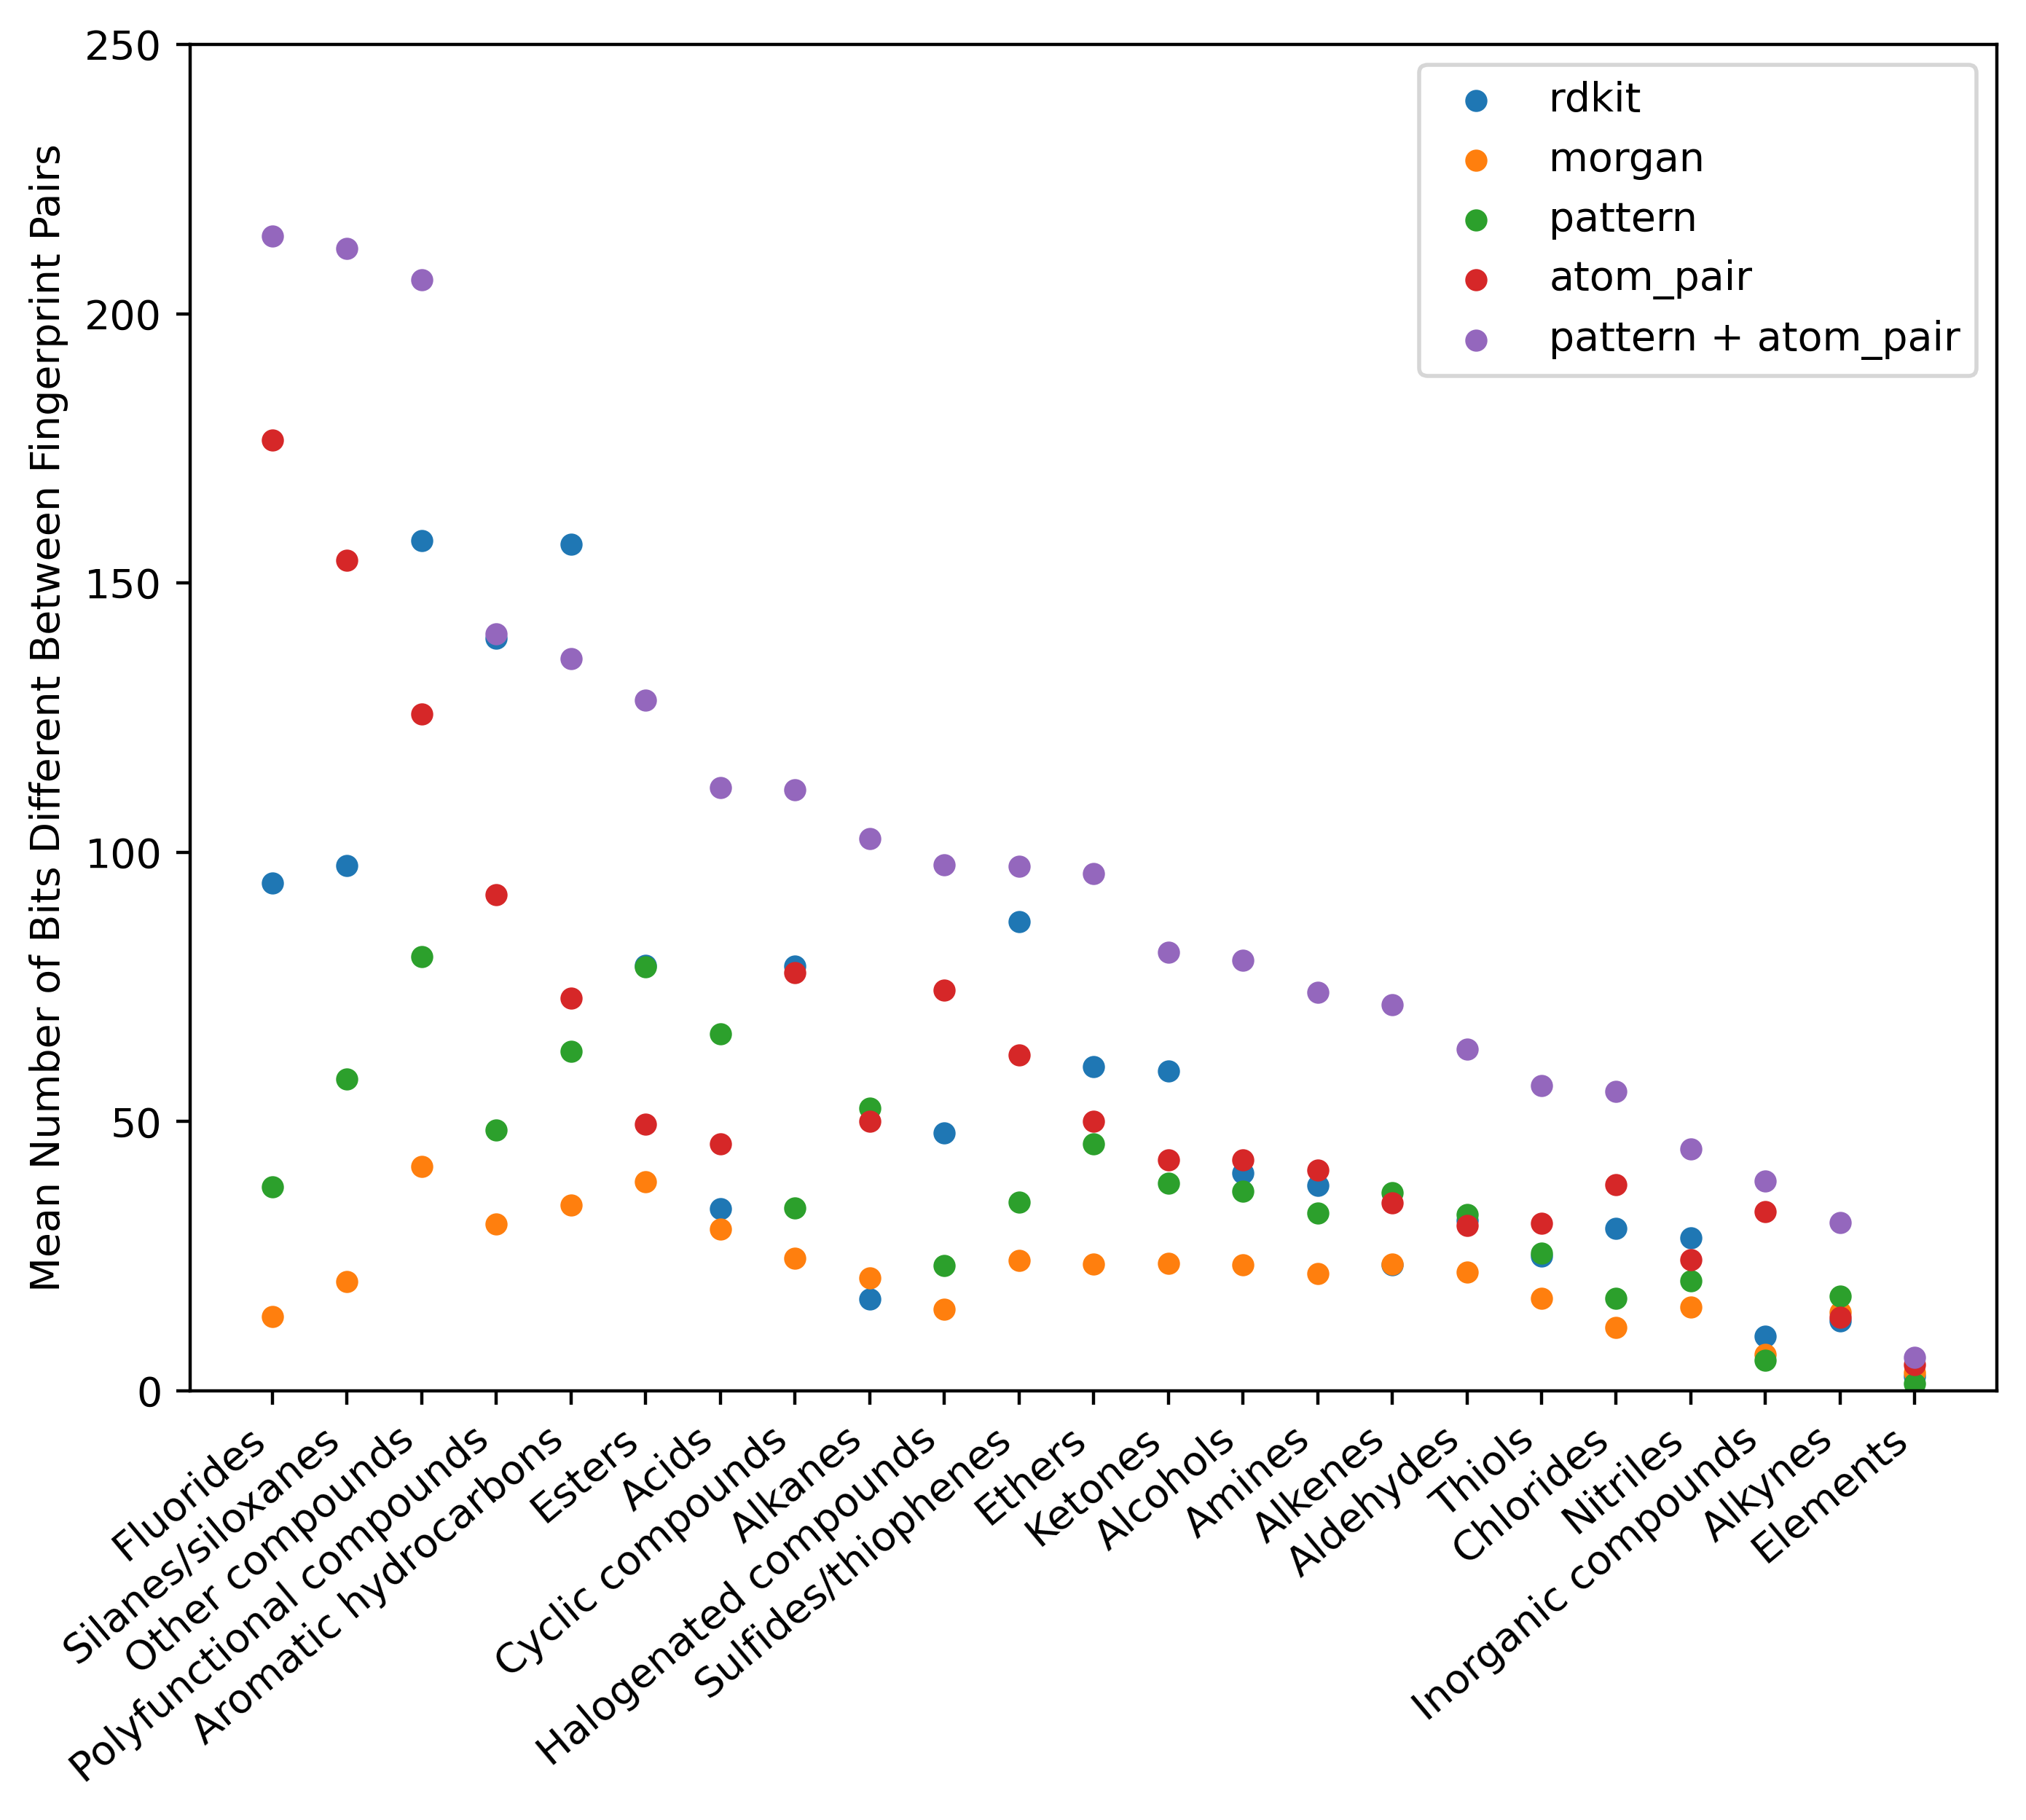

(0.0, 250.0)

In [29]:
default_colours = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"] #, "#8c564b", "#e377c2",  "#7f7f7f", "#bcbd22", "#17becf"]

plt.figure(figsize=(8, 6), dpi=400)
for i = 1:length(means_all[1])
    plt.scatter(sorted_names,sorted_means_restructure[i],color = default_colours[i],s=20)
end

plt.ylabel("Mean Number of Bits Different Between Fingerprint Pairs")
plt.xticks(rotation=40,ha="right")
plt.legend(["rdkit","morgan","pattern","atom_pair","pattern + atom_pair"],loc = "upper right")
plt.ylim([0,250])

In [30]:
pcp_source_params;
processed_data;

In [117]:
unique_values = unique(processed_data[!, :family])
num_repeated_strings_all = []
means_diff_bits_over_fp_pairs_all = []
jaccard_coefficients_all = []
repeated_strings_all = []
fp_lengths_all = []

bits = 2048
radius = 6

for i = 1:length(unique_values) + 1
    
    if i <= length(unique_values)
        println(unique_values[i])
        filtered_data_chem_family = filter(row -> row.family == unique_values[i], processed_data) ;
        filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 
        isomeric_smiles_family = filtered_data_chem_family[!,:isomeric_SMILES]
    else
        println(i)
        filtered_data_chem_family = sort(processed_data, :Mw) 
        isomeric_smiles_family = filtered_data_chem_family[!,:isomeric_SMILES]
    end

    fps_r = []; fps_m = []; fps_ap = []; fps_p = []; fps_tt = []
    fps_r_m = []; fps_r_p = []; fps_r_ap = []; fps_r_tt = []; fps_ap_m = []; fps_ap_p = []; fps_ap_tt = []; fps_tt_m = []; fps_tt_p = []; fps_m_p = [];
    fps_r_ap_tt = []; fps_r_ap_m = []; fps_r_ap_p = []; fps_r_tt_m = []; fps_r_tt_p = []; fps_r_m_p = []; fps_ap_tt_m = []; fps_ap_tt_p = []; fps_ap_m_p = []; fps_tt_m_p = []
    fps_r_ap_tt_m = []; fps_r_ap_tt_p = []; fps_r_ap_m_p = []; fps_r_tt_m_p = []; fps_ap_tt_m_p = [];
    fps_r_ap_tt_m_p = [];

    num_repeated_strings_per_family = []
    fp_lengths_per_family = []
    means_diff_bits_over_fp_pairs_per_family = []
    jaccard_coefficients_per_family = []
    repeated_strings_per_family = []

    for i in isomeric_smiles_family

        mol = get_mol(i)

        fingerprint_functions = [
            (get_rdkit_fp, fps_r),
            (get_morgan_fp, fps_m),
            (get_atom_pair_fp, fps_ap),
            (get_pattern_fp, fps_p),
            (get_topological_torsion_fp, fps_tt),
            
            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_m),
            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_p),
            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_ap),
            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_tt),
            ((mol) -> get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_ap_m),
            ((mol) -> get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_ap_p),
            ((mol) -> get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_ap_tt),
            ((mol) -> get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_tt_m),
            ((mol) -> get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_tt_p),
            ((mol) -> get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_m_p),
        
            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_ap_tt),
            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_ap_m),
            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_ap_p),
            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_tt_m),
            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_tt_p),
            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_m_p),
            ((mol) -> get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_ap_tt_m),
            ((mol) -> get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_ap_tt_p),
            ((mol) -> get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_ap_m_p),
            ((mol) -> get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_tt_m_p),

            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_ap_tt_m),
            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_ap_tt_p),
            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_ap_m_p),
            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_tt_m_p),
            ((mol) -> get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_ap_tt_m_p),
            
            ((mol) -> get_rdkit_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_atom_pair_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_topological_torsion_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_morgan_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)) * get_pattern_fp(mol, Dict{String, Any}("radius" => radius, "nbits" => bits)), fps_r_ap_tt_m_p)
            ]
        
        for (fingerprint_function, fingerprint_storage) in fingerprint_functions
            fp_str = fingerprint_function(mol)
            fingerprint_spec = [parse(Float64, string(c)) for c in fp_str]
            append!(fingerprint_storage, [fingerprint_spec])
        end        

    end

    all_fingerprints = [fps_r, fps_m, fps_ap, fps_p, fps_tt, 
                        fps_r_m, fps_r_p, fps_r_ap, fps_r_tt, fps_ap_m, fps_ap_p, fps_ap_tt, fps_tt_m, fps_tt_p, fps_m_p,
                        fps_r_ap_tt, fps_r_ap_m, fps_r_ap_p, fps_r_tt_m, fps_r_tt_p, fps_r_m_p, fps_ap_tt_m, fps_ap_tt_p, fps_ap_m_p, fps_tt_m_p,
                        fps_r_ap_tt_m, fps_r_ap_tt_p, fps_r_ap_m_p, fps_r_tt_m_p, fps_ap_tt_m_p,
                        fps_r_ap_tt_m_p]
    

    for fingerprints in all_fingerprints
        # Remove repeated columns
            for num = [0, 1]
                num_cols = length(fingerprints[1])
                zero_cols = trues(num_cols)
                for vec in fingerprints
                    zero_cols .&= (vec .== num)
                end
                keep_cols = .!zero_cols # Create a Mask
                fingerprints = [vec[keep_cols] for vec in fingerprints] # Apply Mask
            end
        
            # Fingerprint comparisons for a given chemical family
            repeated_vectors = count_repeated_vectors(fingerprints)
            number_repeated_strings = length(values(repeated_vectors))
        
            repeated_species = []
            
            for i in keys(repeated_vectors)
                # Use a list comprehension to find indices where the vector matches the target_key
                matching_indices = findall(vector -> vector == i, fingerprints)
                for i in  matching_indices
                    # println(processed_data[i,:common_name]) # comment this in to print the names of repeated species
                    push!(repeated_species,processed_data[i,:common_name])
                end
            end

            result_compare = compare_fingerprints(fingerprints)       

            push!(repeated_strings_per_family, repeated_species)
            push!(fp_lengths_per_family, length(fingerprints[1]))
            push!(num_repeated_strings_per_family, number_repeated_strings)
            push!(means_diff_bits_over_fp_pairs_per_family, result_compare[2])
            push!(jaccard_coefficients_per_family, result_compare[3])
            
    end

    push!(num_repeated_strings_all, num_repeated_strings_per_family)
    push!(means_diff_bits_over_fp_pairs_all, means_diff_bits_over_fp_pairs_per_family)
    push!(jaccard_coefficients_all, jaccard_coefficients_per_family)
    push!(repeated_strings_all, repeated_strings_per_family)
    push!(fp_lengths_all, fp_lengths_per_family)

    # @show repeated_strings_per_family
    @show num_repeated_strings_per_family
    # @show means_diff_bits_over_fp_pairs_per_family
    @show jaccard_coefficients_per_family

end


Acids
num_repeated_strings_per_family = Any[1, 1, 0, 1, 4, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
jaccard_coefficients_per_family = Any[0.7004651199760838, 0.7672972071305555, 0.6385397593404416, 0.6193991444739387, 0.7584466105841162, 0.7217185816314645, 0.6545592629411706, 0.6573470673040769, 0.7134866896575386, 0.6799366969186704, 0.6282989471321513, 0.6559342582806027, 0.7480785709886083, 0.6484138837168385, 0.679098788109796, 0.6675255619212724, 0.6825288963010887, 0.6447252466576624, 0.7262134958764758, 0.6675608189976788, 0.6838775442996777, 0.6871735462773934, 0.6407540498698704, 0.6604518683843658, 0.6884936412423999, 0.6880516683745578, 0.6531100225401205, 0.6667088325166723, 0.6903123536608415, 0.6673416717098595, 0.6720185953957346]
Alcohols
num_repeated_strings_per_family = Any[4, 5, 0, 6, 8, 1, 0, 0, 3, 0, 0, 0, 1, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
jaccard_coefficients_per_family = Any[0.8399196251985566, 0.850360

LoadError: InterruptException:

In [198]:
num_rows = length(means_diff_bits_over_fp_pairs_all)
fingerprints = ["r", "m", "ap", "p", "tt", "r + m", "r + p", "r + ap", "r + tt", "ap + m", "ap + p",
                "ap + tt", "tt + m", "tt + p", "m + p", "r + ap + tt", "r + ap + m", "r + ap + p",
                "r + tt + m", "r + tt + p", "r + m + p", "ap + tt + m", "ap + tt + p", "ap + m + p",
                "tt + m + p", "r + ap + tt + m", "r + ap + tt + p", "r + ap + m + p", "r + tt + m + p",
                "ap + tt + m + p", "r + ap + tt + m + p"]

fingerprint_analysis_data = DataFrame(
    Chemical_Family = fill("", num_rows),
    r = fill([0.0], num_rows),
    m = fill([0.0], num_rows),
    ap = fill([0.0], num_rows),
    p = fill([0.0], num_rows),
    tt = fill([0.0], num_rows),
    
    r_m = fill([0.0], num_rows),
    r_p = fill([0.0], num_rows),
    r_ap = fill([0.0], num_rows),
    r_tt = fill([0.0], num_rows),
    ap_m = fill([0.0], num_rows),
    ap_p = fill([0.0], num_rows),
    ap_tt = fill([0.0], num_rows),
    tt_m = fill([0.0], num_rows),
    tt_p = fill([0.0], num_rows),
    m_p = fill([0.0], num_rows),

    r_ap_tt = fill([0.0], num_rows),
    r_ap_m = fill([0.0], num_rows),
    r_ap_p = fill([0.0], num_rows),
    r_tt_m = fill([0.0], num_rows),
    r_tt_p = fill([0.0], num_rows),
    r_m_p = fill([0.0], num_rows),
    ap_tt_m = fill([0.0], num_rows),
    ap_tt_p = fill([0.0], num_rows),
    ap_m_p = fill([0.0], num_rows),
    tt_m_p = fill([0.0], num_rows),

    r_ap_tt_m = fill([0.0], num_rows),
    r_ap_tt_p = fill([0.0], num_rows),
    r_ap_m_p = fill([0.0], num_rows),
    r_tt_m_p = fill([0.0], num_rows),
    ap_tt_m_p = fill([0.0], num_rows),

    r_ap_tt_m_p = fill([0.0], num_rows),
) ;

fingerprint_analysis_data.Chemical_Family[1:23] = unique_values
fingerprint_analysis_data.Chemical_Family[end] = "All Families";

In [199]:
# Assign output fingerprint data to dataframe, structuring each chemical family + fingerprint combination as an array

for i = 1:length(num_repeated_strings_all[1])
    append_array = []

    for j = 1:length(num_repeated_strings_all)
        push!(append_array, [num_repeated_strings_all[j][i], round(jaccard_coefficients_all[j][i], digits=3), round(means_diff_bits_over_fp_pairs_all[j][i], digits=2), fp_lengths_all[j][i]])
    end
    fingerprint_analysis_data[!,1+i] = append_array
end


In [320]:
# create matrices for heat maps

data_jaccard = zeros(Float64,nrow(fingerprint_analysis_data),ncol(fingerprint_analysis_data)-1) ;
data_repeats = zeros(Float64,nrow(fingerprint_analysis_data),ncol(fingerprint_analysis_data)-1) ;
data_mean_different_bits = zeros(Float64,nrow(fingerprint_analysis_data),ncol(fingerprint_analysis_data)-1) ;
data_fingerprint_lengths = zeros(Float64,nrow(fingerprint_analysis_data),ncol(fingerprint_analysis_data)-1) ;

for i = 2:ncol(fingerprint_analysis_data)
    values_jaccard = []
    values_repeats = []
    values_means = []
    values_lengths = []

    for j = 1:nrow(fingerprint_analysis_data)
        value_repeats = fingerprint_analysis_data[j,i][1]
        value_jacccard = fingerprint_analysis_data[j,i][2]
        value_mean = fingerprint_analysis_data[j,i][3]
        value_length = fingerprint_analysis_data[j,i][4]

        push!(values_jaccard,value_jacccard)
        push!(values_repeats,value_repeats)
        push!(values_means,value_mean)
        push!(values_lengths,value_length)
    end
    data_jaccard[:,i-1] = values_jaccard
    data_repeats[:,i-1] = values_repeats
    data_mean_different_bits[:,i-1] = values_means
    data_fingerprint_lengths[:,i-1] = values_lengths

end

data_in_repeats_bounded = min.(data_in_repeats, 1);

min_value_jaccard = minimum(jaccard_matrix[.!isnan.(jaccard_matrix) .& (jaccard_matrix .!= 0)])
println(min_value_jaccard)

0.5483870967741935


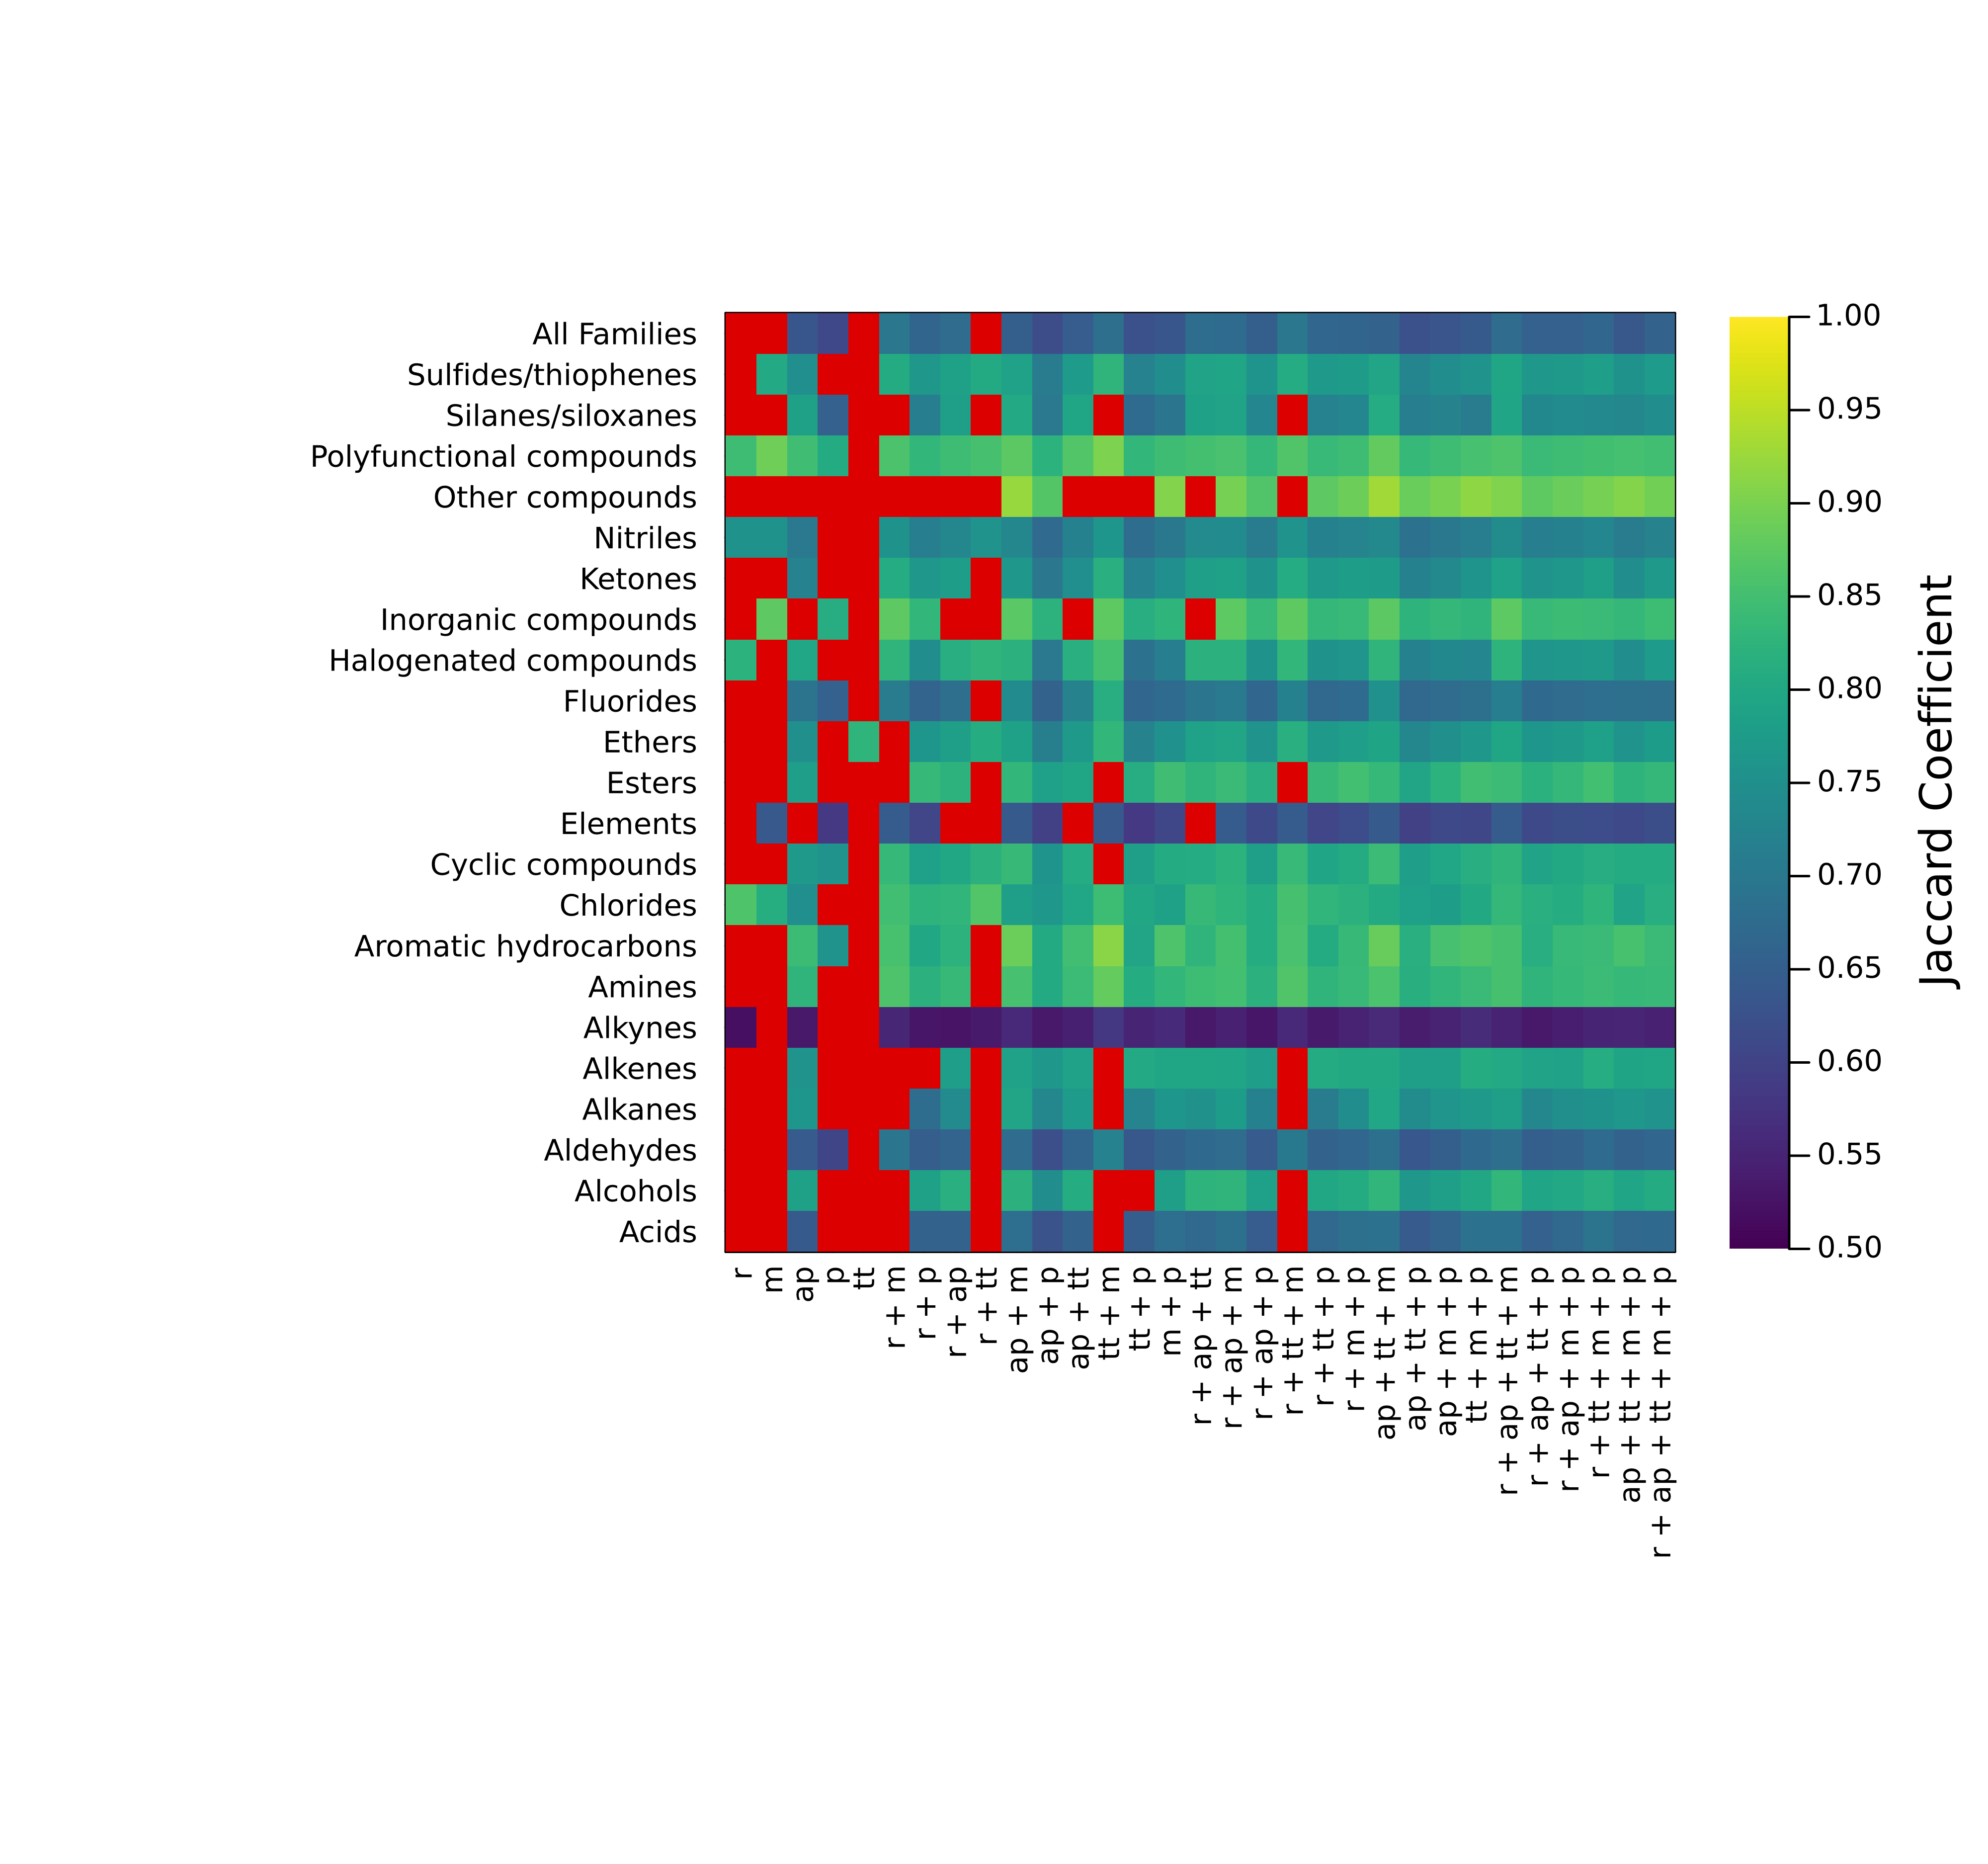

In [321]:
custom_map = cgrad([RGBA(220/255,0,0,0), RGBA(220/255,0,0,1)])
clims = (0.5,1)
size_fig = (800,750)

# Creating a heatmap
heatmap(data_in_jaccard, c=:viridis, dpi=500, clim = (0.5,1),framestyle=:box, aspect_ratio=:auto, size=size_fig,xrotation = 90,margin = 2Plots.cm)
heatmap!(data_in_repeats_norm, c=custom_map, dpi=500, clim = (0.5,1),framestyle=:box, aspect_ratio=:auto, size=size_fig, colorbar=false,xrotation = 90,margin = 3Plots.cm)

yticks!(1:length(fingerprint_analysis_data.Chemical_Family), fingerprint_analysis_data.Chemical_Family)
xticks!(1:length(fingerprints), fingerprints)  # Add rotation here

p_all = scatter!([NaN], [NaN], zcolor=[NaN], clims=clims, label="", c=:viridis, background_color_subplot=:transparent, markerstrokecolor=:transparent, framestyle=:none, inset=bbox(0.05, -0.08, 0.7, 0.5, :center, :right), subplot=2)

annotate!([(40, 12, text("Jaccard Coefficient", 12, :DejaVuSans, rotation=90))])

# savefig("Jaccard_Repeat_Overlay.png")


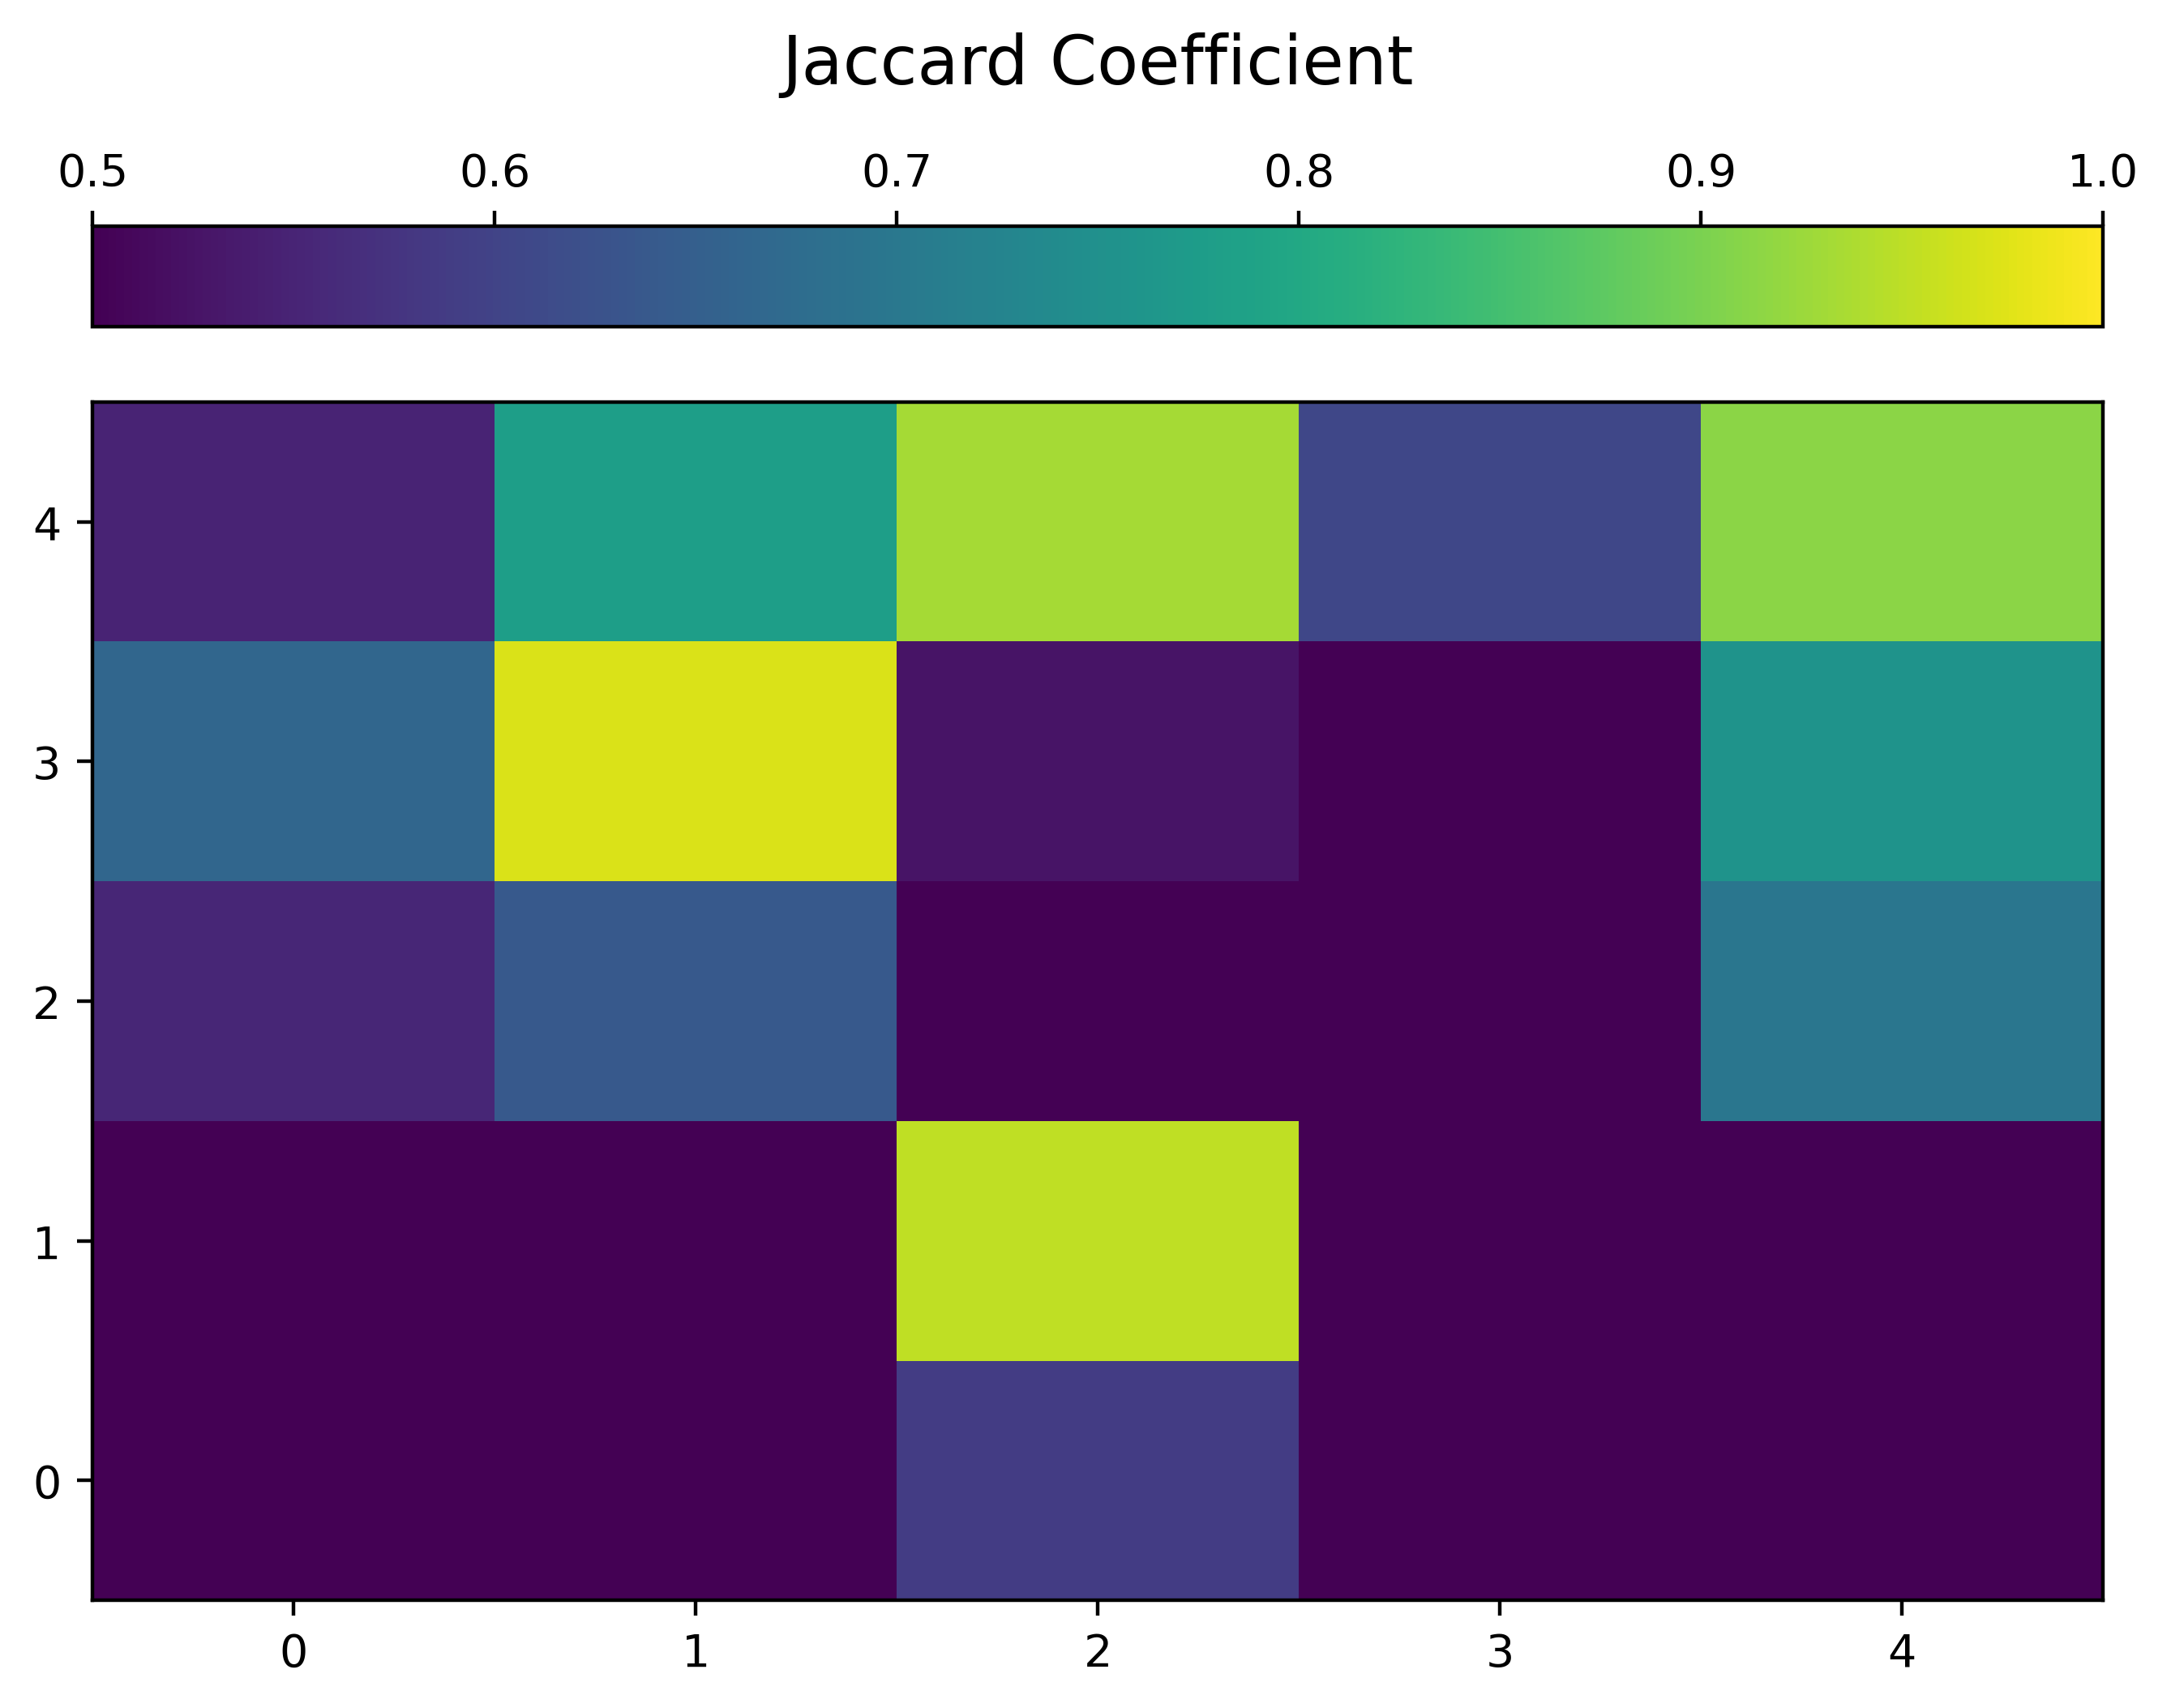

In [40]:
# create a horizontal colourbar - crop this if necessary
# plt.figure(figsize=(8, 6), dpi=400)
# plt.imshow(data_in, cmap="viridis", interpolation="nearest", origin="lower", aspect="auto", vmin=0.5, vmax=1)
# cbar = plt.colorbar(orientation="horizontal",location="top")
# cbar.set_label(label="Jaccard Coefficient",size=15,labelpad=15)

# plt.savefig("horizontal_colourbar.png", dpi=400)

In [ ]:

# rdkit
# atom_pair
# topological_torsion
# morgan
# pattern

# rdkit + morgan
# rdkit + pattern
# rdkit + atom_pair
# rdkit + topological_torsion
# atom_pair + morgan
# atom_pair + pattern # tried this
# atom_pair + topological_torsion
# topological_torsion + morgan
# topological_torsion + pattern
# morgan + pattern

# rdkit + atom_pair + topological_torsion
# rdkit + atom_pair + morgan
# rdkit + atom_pair + pattern
# rdkit + topological_torsion + morgan
# rdkit + topological_torsion + pattern
# rdkit + morgan + pattern
# atom_pair + topological_torsion + morgan
# atom_pair + topological_torsion + pattern
# atom_pair + morgan + pattern
# topological_torsion + morgan + pattern

# rdkit + atom_pair + topological_torsion + morgan
# rdkit + atom_pair + topological_torsion + pattern
# rdkit + atom_pair + morgan + pattern
# rdkit + topological_torsion + morgan + pattern
# atom_pair + topological_torsion + morgan + pattern

# rdkit + atom_pair + topological_torsion + morgan + pattern